# Evaluation of the actions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from typing import Dict, List
from collections import defaultdict


from evaluation.result_analysis import process_eval_data_multiple_agents, \
                         get_analysis_objects, \
                        compile_table_df

/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


## Run evaluation - no outages

In [14]:
EVAL_PATHS = {"PPO Native": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13/90_test_chronics","10803_00000"),
                "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_Greedy_154e3_00006_6_num_workers=6,seed=28_2022-03-12_22-22-53/90_test_chronics", "154e3_00006"),
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_190e1_00002_2_initial_alpha=1.221,num_workers=6,prioritized_replay=True,seed=50_2022-03-12_13-58-36/145_test", "190e1_00002" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_1e1e2_00003_3_initial_alpha=1.35,num_workers=8,prioritized_replay=True,seed=42_2022-03-12_15-35-20/80_test", "1e1e2_00003"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13/None_test_chronics", "10803_00000"),
}


data_per_algorithm = process_eval_data_multiple_agents(EVAL_PATHS)

# Compile the dataframe from which we will later plot the results
df = compile_table_df(data_per_algorithm)

ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'
100%|██████████| 200/200 [00:00<00:00, 23410.94it/s]
/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, wh

In [20]:
data_per_algorithm["PPO Native"].agent_info#.chronic_to_num

AttributeError: 'dict' object has no attribute 'agent_info'

In [47]:
df.columns
df[['num_actions', 'num_topo_actions', 'No Op']], df["num_topo_actions"]/df["num_actions"]

(                num_actions  num_topo_actions     No Op
 PPO Native            12011            5514.0  0.540921
 PPO Substation         8850            3056.0  0.654689
 SAC Native            27498             550.0  0.979999
 SAC Substation        23552            2276.0  0.903363
 Greedy                 7438            4534.0  0.390428,
 PPO Native        0.459079
 PPO Substation    0.345311
 SAC Native        0.020001
 SAC Substation    0.096637
 Greedy            0.609572
 dtype: float64)

In [92]:
((df.num_topo_actions/df.mean_chronic_length)/sum(df.num_topo_actions/df.mean_chronic_length))

PPO Native        0.346723
PPO Substation    0.185442
SAC Native        0.035775
SAC Substation    0.142394
Greedy            0.289666
dtype: float64

### Mean chronic length plus + number of actions that change the topology

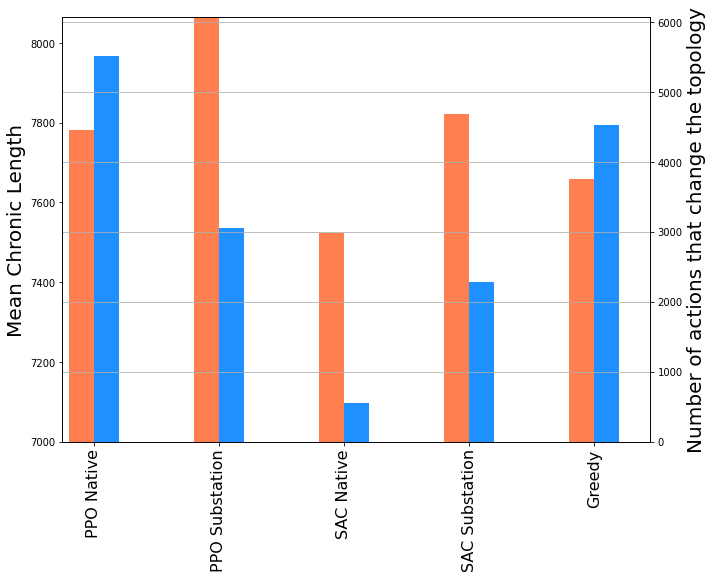

In [49]:
fig = plt.figure(figsize=(10,8), tight_layout=True) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2
colors = sns.color_palette('pastel')

df.mean_chronic_length.plot(kind='bar', color='coral', ax=ax, width=width, position=1)
df.num_topo_actions.plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0)
# (1-df["No Op"]).plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0)

ax.set_ylabel('Mean Chronic Length', size = 20)
# ax2.set_ylabel('Number of actions that change the topology', size = 20)


ax.set_ylim(7000, 8064)
ax2.set_ylim(0, df.num_topo_actions.max()*1.1)
# ax2.set_ylim(0, 1)

ax.set_xticklabels(df.index, fontsize=16)

plt.grid(axis = "y")
plt.show()

# ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/performance_agents_test_split.jpg", dpi = 200)
#plt.savefig()


In [95]:
np.mean(df.num_topo_actions/(df.mean_chronic_length))

0.40871818299296897

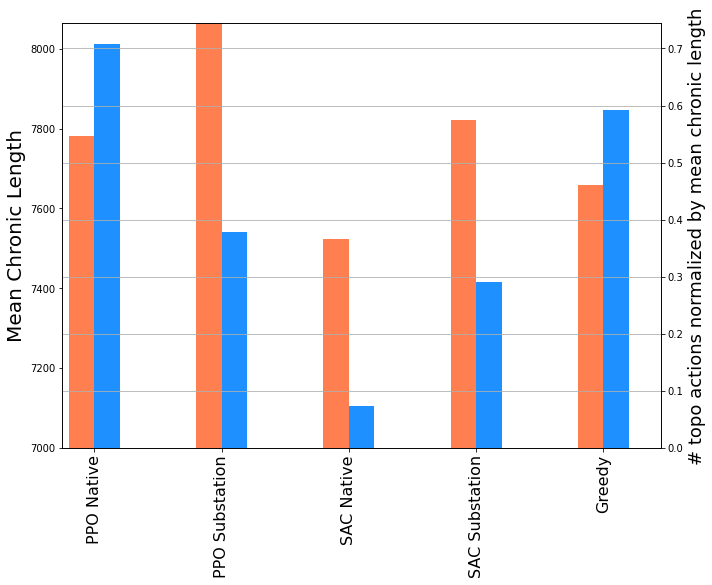

In [93]:
fig = plt.figure(figsize=(10,8), tight_layout=True) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2
colors = sns.color_palette('pastel')

df.mean_chronic_length.plot(kind='bar', color='coral', ax=ax, width=width, position=1)
# df.num_topo_actions.plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0)
(df.num_topo_actions/(df.mean_chronic_length)).plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0)



ax.set_ylabel('Mean Chronic Length', size = 20)
# ax2.set_ylabel('Fraction of actions that change the topology', size = 20)
ax2.set_ylabel('# topo actions normalized by mean chronic length', size = 18)

ax.set_ylim(7000, 8064)
# ax2.set_ylim(0, df.num_topo_actions.max()*1.1)
# ax2.set_ylim(0, 1)

ax.set_xticklabels(df.index, fontsize=16)

plt.grid(axis = "y")
plt.show()

ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/performance_agents_test_split.jpg", dpi = 200)
#plt.savefig()


### Aggregated substation actions excluding no op and normalized

-0.2
-0.1
0.0
0.1
0.2


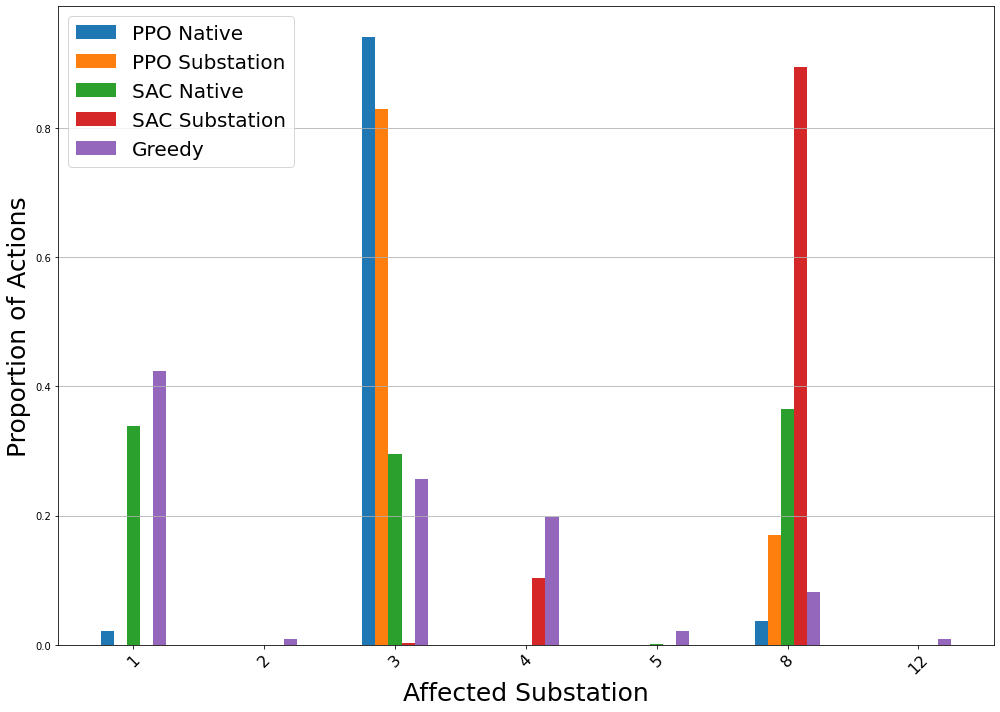

In [5]:
# cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12, "Implict No op", "Explicit No op"]]
df_op = df[["1", "2","3", "4", "5", "8", "12"]].div(df[["1", "2","3", "4", "5", "8", "12"]].sum(axis=1), axis=0)
cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12]]



X_axis = np.arange(df_op.loc[df_op.index[0]][cols_this_plot].shape[0])
ax = plt.figure(figsize=(14,10), tight_layout=True)
colors = sns.color_palette('pastel')
offset = 0.1
for i, algo_type in enumerate(df_op.index):
    print((i - len(df_op.index)//2)*offset)
    plt.bar(X_axis + (i - len(df_op.index)//2)*offset , df_op.loc[algo_type][cols_this_plot], 0.1, label = algo_type)
    #plt.bar(X_axis + 0.2, df_op.loc["PPO Substaion"][:-1], 0.4, label = 'PPO Substation')

plt.xticks(X_axis, df_op.loc[df_op.index[0]][cols_this_plot].index, rotation = 45)

plt.xticks(fontsize=16)
plt.xlabel('Affected Substation', size = 25)
plt.ylabel('Proportion of Actions', size = 25)
#plt.title('Behaviours of different agents', size = 24)
plt.legend( prop={'size': 20})
plt.grid(axis = "y")
plt.show()

# ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/affected_substation_distr_op_test_split.jpg", dpi = 200)
#plt.savefig()

### Get the df ready as a Latex table

In [10]:
include_cols = [
  ('mean_chronic_length',"Mean chronic length"),
       ('mean_normalized_reward', "Mean normalized reward"),
     ('num_topo_actions', "Number of topological changes"),
        ('num_imperfect_chron', "Number unsolved chronics"),
    ('num_unique_topos', "Number of unique topologies"),
     ('mean_topo_depth', "Mean topological depth"),
      ('std_topo_depth', "Standard deviation of topological depth"),
      ('num_unqiue_seq', "Number unique sequences"),
      ("mean_seq_len", "Mean sequence length"),
      ("std_seq_len", "Standard deviation of sequence length"),
       ('mean_repeat_seq', "Mean sequence repeatability"),
       ( 'std_repeat_seq', "Standard deviation of sequence repeatability"),
         
         ]


df_latex = df[[elem[0] for elem in include_cols]]
df_latex.columns = [elem[1] for elem in include_cols]

In [11]:
from tabulate import tabulate
from texttable import Texttable

import latextable

table = Texttable(0)
table.set_cols_align(["c"] * (df_latex.shape[0]+1) )
#table.set_deco(Texttable.HEADER | Texttable.BORDER)
table.set_precision(2)

add_rows = [[""] + list(df_latex.T.columns)]
for row in df_latex.T.iterrows():
    add_rows.append([row[0]] + list(row[1])) 

print(add_rows)
table.add_rows(add_rows)


print('Tabulate Table:')
print(tabulate(add_rows, headers='firstrow'))

print('\nTexttable Table:')
print(table.draw())


print('\nTexttable Latex:')
print(latextable.draw_latex(table, caption="A comparison of rocket features.", label = "table:noOutagesSummaryTable", use_booktabs = False))

[['', 'PPO Native', 'PPO Substation', 'SAC Native', 'SAC Substation', 'Greedy'], ['Mean chronic length', 7781.99, 8064.0, 7522.95, 7821.42, 7659.325], ['Mean normalized reward', 6870.428440533371, 6874.938557738544, 6859.098650086362, 6860.191709917906, 6831.43936678755], ['Number of topological changes', 5514.0, 3056.0000000000005, 550.0, 2275.9999999999986, 4533.999999999999], ['Number unsolved chronics', 15.0, 0.0, 27.0, 15.0, 23.0], ['Number of unique topologies', 57.0, 62.0, 8.0, 65.0, 1916.0], ['Mean topological depth', 4.375645228487223, 3.5764922013327443, 4.002623921803677, 2.3940974615853983, 5.760107053352288], ['Standard deviation of topological depth', 1.207794419125838, 0.7916390940188854, 1.2201232243562836, 0.8329653942917319, 1.718925174249208], ['Number unique sequences', 257.0, 47.0, 1.0, 47.0, 242.0], ['Mean sequence length', 3.2244897959183674, 2.0, nan, 2.1481481481481484, 2.0], ['Standard deviation of sequence length', 1.2166415151664391, 0.0, nan, 0.355246779504

### Performance for chronics from validation and train sets

In [27]:
# Eval paths for models trained with train/val/test split
EVAL_PATHS_TRAIN = {"PPO Native": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13/90_train_chronics","10803_00000"),
                "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_Greedy_154e3_00006_6_num_workers=6,seed=28_2022-03-12_22-22-53/90_train_chronics", "154e3_00006"),
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_190e1_00002_2_initial_alpha=1.221,num_workers=6,prioritized_replay=True,seed=50_2022-03-12_13-58-36/145_train_chronics", "190e1_00002" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_1e1e2_00003_3_initial_alpha=1.35,num_workers=8,prioritized_replay=True,seed=42_2022-03-12_15-35-20/80_train_chronics", "1e1e2_00003"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13/None_train_chronics", "10803_00000"),
                #"New SAC": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_96d3e_00009_9_initial_alpha=1.105,num_workers=6,entropy_learning_rate=1e-20,seed=31,train_batch_size=1024_2022-03-15_18-53-48_40_train_chronics", "96d3e_00009"),
}

EVAL_PATHS_VAL = {"PPO Native": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13/90_val_chronics","10803_00000"),
                "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/PPO_Grid_Gym_Greedy_154e3_00006_6_num_workers=6,seed=28_2022-03-12_22-22-53/90_val_chronics", "154e3_00006"),
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_190e1_00002_2_initial_alpha=1.221,num_workers=6,prioritized_replay=True,seed=50_2022-03-12_13-58-36/145_val_chronics", "190e1_00002" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_1e1e2_00003_3_initial_alpha=1.35,num_workers=8,prioritized_replay=True,seed=42_2022-03-12_15-35-20/80_val_chronics", "1e1e2_00003"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_PPO_Grid_Gym_10803_00000_0_num_workers=6,seed=21_2022-03-12_08-00-13/None_val_chronics", "10803_00000"),
                #"New SAC": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/SAC_Grid_Gym_Greedy_96d3e_00009_9_initial_alpha=1.105,num_workers=6,entropy_learning_rate=1e-20,seed=31,train_batch_size=1024_2022-03-15_18-53-48_40_val_chronics", "96d3e_00009"),
}

data_per_algorithm_train = {} 
data_per_algorithm_val = {}


for name, path in EVAL_PATHS_TRAIN.items():
    if name not in data_per_algorithm_train:
        if isinstance(path, tuple):
            path, wandb_run_id = path
        else: 
            wandb_run_id = None
        print(f"Processing name {name} ")
        data_per_algorithm_train[name] = {} 
        agent_info, action_analysis, topo_vects, rewards, avg_time_per_step = get_analysis_objects(path,wandb_run_id )
        data_per_algorithm_train[name]["agent_info"] = agent_info
        data_per_algorithm_train[name]["action_analysis"] = action_analysis
    else:
        continue

for name, path in EVAL_PATHS_VAL.items():
    if name not in data_per_algorithm_val:
        if isinstance(path, tuple):
            path, wandb_run_id = path
        else: 
            wandb_run_id = None
        print(f"Processing name {name} ")
        data_per_algorithm_val[name] = {} 
        agent_info, action_analysis, topo_vects, rewards, avg_time_per_step = get_analysis_objects(path,wandb_run_id )
        data_per_algorithm_val[name]["agent_info"] = agent_info
        data_per_algorithm_val[name]["action_analysis"] = action_analysis
    else:
        continue

    

Processing name PPO Native 
ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Native 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name Greedy 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Native 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Native 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name Greedy 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


In [9]:
for name in EVAL_PATHS_TRAIN.keys():
    train_mean = data_per_algorithm_train[name]["agent_info"].mean_chronic_length
    val_mean = data_per_algorithm_val[name]["agent_info"].mean_chronic_length
    test_mean = data_per_algorithm[name]["agent_info"].mean_chronic_length
    print("Model", name)
    print("Train mean: ", train_mean)
    print("Val mean: ", val_mean)
    print("Test mean: ", test_mean)

    print(f"Weighted average is {0.7*train_mean + 0.2*val_mean + 0.1*test_mean}")
    print("-"*50)

Model PPO Native
Train mean:  7930.052857142857
Val mean:  7941.2
Test mean:  7781.99
Weighted average is 7917.475999999999
--------------------------------------------------
Model PPO Substation
Train mean:  8046.142857142857
Val mean:  8034.65
Test mean:  8064.0
Weighted average is 8045.629999999999
--------------------------------------------------
Model SAC Native
Train mean:  7730.644285714286
Val mean:  7864.98
Test mean:  7522.95
Weighted average is 7736.742
--------------------------------------------------
Model SAC Substation
Train mean:  7704.92
Val mean:  7743.74
Test mean:  7821.42
Weighted average is 7724.333999999999
--------------------------------------------------
Model Greedy
Train mean:  7860.544285714286
Val mean:  7705.75
Test mean:  7659.325
Weighted average is 7809.463500000001
--------------------------------------------------


In [31]:
# Median calculation

for name in EVAL_PATHS_TRAIN.keys():
    train_median = [steps[-1] for chronic,steps in data_per_algorithm_train[name]['agent_info'].chronic_to_num.items()]
    val_median = [steps[-1] for chronic,steps in data_per_algorithm_val[name]['agent_info'].chronic_to_num.items()]
    test_median = [steps[-1] for chronic,steps in data_per_algorithm[name]['agent_info'].chronic_to_num.items()]


    print("Model", name)
    print("Train median: ", np.quantile(train_median, 0.5))
    print("Val median: ", np.quantile(val_median, 0.5))
    print("Test median: ", np.quantile(test_median, 0.5))


    print(f"Overall median is {np.quantile(train_median + val_median + test_median, 0.5)}")
    print("-"*50)

Model PPO Native
Train median:  8064.0
Val median:  8064.0
Test median:  8064.0
Overall median is 8064.0
--------------------------------------------------
Model PPO Substation
Train median:  8064.0
Val median:  8064.0
Test median:  8064.0
Overall median is 8064.0
--------------------------------------------------
Model SAC Native
Train median:  8064.0
Val median:  8064.0
Test median:  8064.0
Overall median is 8064.0
--------------------------------------------------
Model SAC Substation
Train median:  8064.0
Val median:  8064.0
Test median:  8064.0
Overall median is 8064.0
--------------------------------------------------
Model Greedy
Train median:  8064.0
Val median:  8064.0
Test median:  8064.0
Overall median is 8064.0
--------------------------------------------------


### Obtaining the reward plots from wandb

In [10]:
import wandb
import pandas as pd 

api = wandb.Api()
wandb_run_id_dict = {key:val[1] for key,val in EVAL_PATHS.items()}
the_run = wandb_run_id_dict['PPO Native'].split("_")[0]
runs = api.runs(f"bmanczak/grid2op") # all runs in Grid2Op project

get_runs = []
# Restrict the runs to those that have the same run_id as the ones used in Eval Paths
for key, val in EVAL_PATHS.items():
    if key != "Greedy": # Greedy is not trained
        get_runs.append(val[1].split("_")[0])

In [12]:
summary_list, config_list, name_list, episode_reward_mean = [], [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 

    save_run = False

    for name in get_runs:
        if name in run.name:
            save_run = True
            break
   
    if save_run:
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        episode_reward_mean.append(run.history()["episode_reward_mean"])

runs_dict = {
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "episode_reward_mean":episode_reward_mean
    }


In [13]:
df_rewards = pd.DataFrame(runs_dict["episode_reward_mean"], index=runs_dict["name"])#.head()
def process_wandb_name(name):
    name_lst = name.split("_")
    algo_type = name_lst[0].split("_")[0]
    # print(name_lst)
    is_greedy = "Substation" if name_lst[3] == "Greedy" else "Native"
     
    return f"{algo_type} {is_greedy}"

# Add types: PPO/SAC Native/Greedy
df_rewards["type"] = list(pd.Series(df_rewards.index).apply(lambda name:process_wandb_name(name) ))

# Scale the rewards of SAC by the "scale_reward_factore" which is 3 for us
df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] / 3

df_rewards.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,type
PPO_Grid_Gym_Greedy_154e3_00007,4914.919505,5081.491908,4886.811688,5061.432977,4924.267768,4994.221580,4872.495687,5003.389465,5148.192172,5291.768002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PPO Substation
SAC_Grid_Gym_190e1_00013,108.425877,77.774991,75.452483,69.834430,61.486426,155.973341,207.302051,215.733038,319.390593,360.788356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAC Native
PPO_Grid_Gym_Greedy_154e3_00008,5006.674132,5062.034512,5117.848147,4967.040639,4956.877643,5061.414263,5050.116094,5165.758675,5467.414172,5568.823401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PPO Substation
SAC_Grid_Gym_190e1_00007,100.144820,132.371906,131.161381,131.544569,89.545462,100.096703,100.320746,122.928264,114.447613,87.096445,...,4357.001411,4329.514088,4354.434439,4263.217424,4248.003419,4169.855141,4119.885173,4047.351402,3974.588469,SAC Native
PPO_Grid_Gym_Greedy_154e3_00005,5707.009491,5556.083454,5237.503692,5318.010250,5409.731052,5439.655303,5271.762495,5142.756602,5271.158640,5402.130580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PPO Substation


(223, 4) (223, 4)


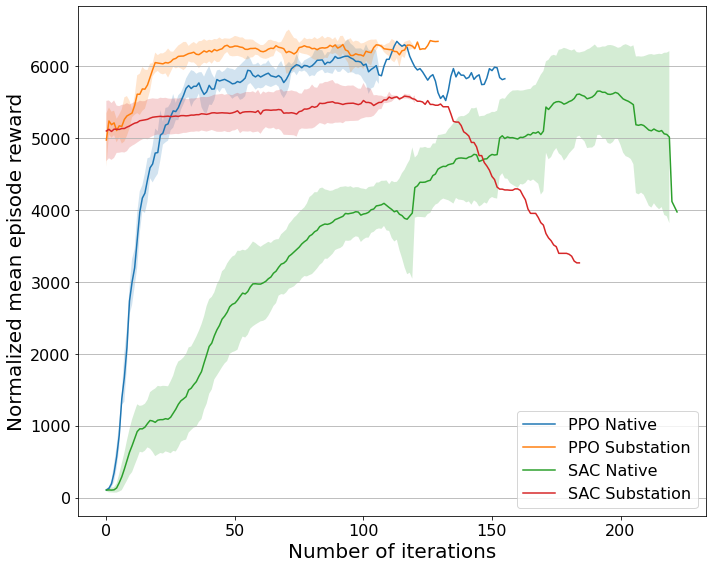

In [14]:
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.legend(list(temp_mean.columns), prop = {'size':16})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of iterations', size = 20)
plt.ylabel('Normalized mean episode reward', size = 20)
# plt.legend(list(temp_mean.columns), prop = {'size':16})
plt.grid(axis = "y")
plt.show()

# ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/training_reward_agents.jpg", dpi = 200)

### Obtain the reward plot from Tensorboard logs

In [2]:
import os
import numpy as np
import pandas as pd

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def make_df(out_func, use_keys):
    """
    Small utility function to fix the dataframe creation in the function below.
    """
    out = {}

    for key, val in out_func.items():
        if key in use_keys:
            # out[key] = np.array(val).flatten() # this ignores "steps"
            out[key] = {key:val["value"] for key, val in val.to_dict().items()}

    return pd.DataFrame.from_dict(out)
    

def tabulate_events(dpath, use_keys = [ 'ray/tune/episode_reward_mean', 'ray/tune/evaluation/episode_reward_mean',\
                                          'ray/tune/custom_metrics/num_env_steps_mean', 'ray/tune/evaluation/custom_metrics/num_env_steps_mean']):

    final_out = {}
    for dname in os.listdir(dpath):
        if ".DS_Store" in dname:
            continue
        print(f"Converting run {dname}",end="")
        ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
        tags = ea.Tags()['scalars']

        out = {}

        for tag in tags:
            if tag not in use_keys:
                continue 
            tag_values=[]
            wall_time=[]
            steps=[]

            for event in ea.Scalars(tag):
               # print(event)
                tag_values.append(event.value)
                wall_time.append(event.wall_time)
                steps.append(event.step)

            # out[tag]=pd.DataFrame(data=dict(zip(steps,np.array([tag_values,wall_time]).transpose())), columns=steps,index=['value','wall_time'])
            out[tag]=pd.DataFrame(data=dict(zip(steps,np.array(tag_values))), index = ["value"], columns=steps)

        if len(tags)>0:  
            df = pd.DataFrame() 
            try:
                df = make_df(out, use_keys)
                print("- Done")
                # return out 
            except Exception as e:
                print(f"\n{e}")
                print("- Failed")
                # return out
                continue
        else:
            print('- Not scalers to write')
            continue

        final_out[dname] = df

    return final_out

# Paths with 1000 iterations

paths = [
        "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_in_env/PPO_Grid_Gym_37b7c",
        "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_mlp_substation/PPO_Grid_Gym_Greedy_2fc5b",
        "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env/SAC_Grid_Gym_350a7",
        "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_greedy_substation/SAC_Grid_Gym_Greedy_a6e4e",
         "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic_no_outages/PPO_HierarchicalGridGym_3524e"
    ]            
# steps_good = tabulate_events(path)
dft = pd.DataFrame()
for path in paths:
    steps = tabulate_events(path)
    dft =  pd.concat([dft, pd.concat(steps.values(),keys=steps.keys()).reset_index()])


df_unprocessed = dft #pd.concat(steps.values(),keys=steps.keys()).reset_index().loc[:, ["level_0", "level_1", "ray/tune/episode_reward_mean"]]#set_index(["level_1"])
runs = np.unique(df_unprocessed.level_0)

name_list, episode_reward_mean, evaluation_num_steps, training_num_steps = [], [], [], []
for run in runs: 

    name_list.append(run)
    episode_reward_mean.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/episode_reward_mean"]))
    evaluation_num_steps.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/evaluation/custom_metrics/num_env_steps_mean"]))
   # training_num_steps.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/custom_metrics/num_env_steps_mean"]))

runs_dict = {
    "name": name_list,
    "episode_reward_mean":episode_reward_mean
    }

# def process_wandb_name(name):
#     name_lst = name.split("_")
#     algo_type = name_lst[0].split("_")[0]
#     # print(name_lst)
#     is_greedy = "Substation" if name_lst[3] == "Greedy" else "Native"
     
#     return f"{algo_type} {is_greedy}" 

def process_wandb_name(name):
    name_lst = name.split("_")
    algo_type = name_lst[0].split("_")[0]
    # print(name_lst)
    if name_lst[1] == "HierarchicalGridGym":
        is_greedy = "Hierarchical"
    else:
        is_greedy = "Substation" if name_lst[3] == "Greedy" else "Native"
     
    return f"{algo_type} {is_greedy}" 
      
df_rewards = pd.DataFrame(runs_dict["episode_reward_mean"], index=runs_dict["name"])#.head()
df_eval_steps = pd.DataFrame(evaluation_num_steps, index=runs_dict["name"])#.head()

# Add types: PPO/SAC Native/Greedy
df_rewards["type"] = list(pd.Series(df_rewards.index).apply(lambda name:process_wandb_name(name) ))
df_eval_steps["type"] = list(pd.Series(df_eval_steps.index).apply(lambda name:process_wandb_name(name) ))

df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] / 3
df_rewards.loc[df_rewards["type"].isin(["PPO Hierarchical"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["PPO Hierarchical"]) ,df_rewards.columns[:-1]] / 2

Converting run PPO_Grid_Gym_37b7c_00001_1_num_workers=4,seed=81_2022-06-22_07-14-24- Done
Converting run PPO_Grid_Gym_37b7c_00002_2_num_workers=2,seed=97_2022-06-21_16-20-22- Done
Converting run PPO_Grid_Gym_37b7c_00007_7_num_workers=2,seed=65_2022-06-21_16-19-53- Done
Converting run PPO_Grid_Gym_37b7c_00008_8_num_workers=2,seed=49_2022-06-21_16-20-07- Done
Converting run PPO_Grid_Gym_37b7c_00003_3_num_workers=4,seed=72_2022-06-21_16-20-38- Done
Converting run PPO_Grid_Gym_37b7c_00000_0_num_workers=6,seed=42_2022-06-21_16-19-53- Done
Converting run PPO_Grid_Gym_37b7c_00004_4_num_workers=2,seed=74_2022-06-22_07-58-30- Done
Converting run PPO_Grid_Gym_37b7c_00006_6_num_workers=4,seed=55_2022-06-22_09-55-30- Done
Converting run PPO_Grid_Gym_37b7c_00005_5_num_workers=6,seed=60_2022-06-22_19-33-44- Done
Converting run PPO_Grid_Gym_Greedy_2fc5b_00004_4_num_workers=2,seed=74_2022-06-22_08-37-52- Done
Converting run PPO_Grid_Gym_Greedy_2fc5b_00003_3_num_workers=4,seed=72_2022-06-21_16-20-09- D

In [8]:
temp_mean.drop(["PPO Hierarchical"], axis= 1)

type,PPO Native,PPO Substation,SAC Native,SAC Substation
0,125.069380,5052.858615,108.887658,5168.785742
1,130.289161,5086.550347,106.128986,5190.203971
2,182.085164,5037.028809,108.167721,5202.099674
3,276.271349,4985.552246,154.727383,5205.673991
4,595.907793,5044.431207,206.217446,5212.634993
...,...,...,...,...
195,6121.053711,6299.824219,5344.990389,4502.627214
196,6166.861049,6285.336133,5345.001127,4514.412923
197,6148.800014,6312.013867,5340.401388,4524.765430
198,6164.093331,6321.455469,5344.926619,4549.508659


(200, 4) (200, 4)


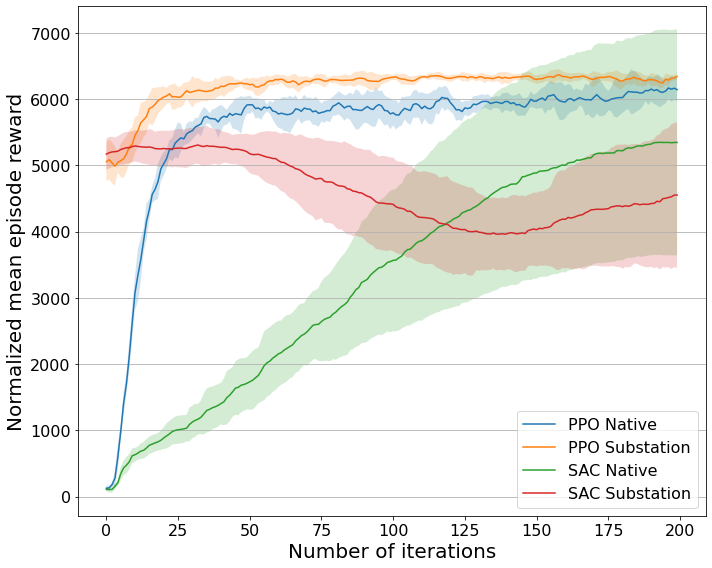

In [10]:
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

temp_mean = temp_mean.drop(["PPO Hierarchical"], axis= 1)
temp_std = temp_std.drop(["PPO Hierarchical"], axis= 1)

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.legend(list(temp_mean.columns), prop = {'size':16})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of iterations', size = 20)
plt.ylabel('Normalized mean episode reward', size = 20)
# plt.legend(list(temp_mean.columns), prop = {'size':16})
plt.grid(axis = "y")
plt.show()


ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/training_reward_agents.jpg", dpi = 200)

In [4]:
agent_type_to_log_file = {"PPO Native": "PPO_in_env_outages",
                          "PPO Substation": "PPO_mlp_substation_outages",
                          "SAC Native": "SAC_in_env_outages",
                          "SAC Substation": "SAC_greedy_substation_outages",
                          "PPO Hierarchical": "PPO_full_hier_mlp_outages_share_critic"}


max_num_steps = df_eval_steps.groupby("type", dropna=False).agg("max").idxmax(axis = 1)

for type, col in zip(max_num_steps.index, max_num_steps):
    col = col#[0] # discard the "max" from groupby
    print("Agent type", type)
    print("Checkpoint number is: ", col + 1)
    temp_df = df_eval_steps.loc[df_eval_steps["type"] == type, col]
    model_name = temp_df.idxmax()
    best_checkpoint = temp_df.max() + 1

    print("Best number of evaluation steps: ", best_checkpoint)
    print("Model name", model_name)
    

    agent_type = type.split(" ")[0].lower()
    run_name = model_name.split("000")[0].strip("_")
    checkpoint_path = f" /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/{agent_type_to_log_file[type]}/{run_name}/{model_name}"
    checkpoint_num = col + 1

    eval_command = f"python evaluation/run_eval.py --agent_type {agent_type} --checkpoint_path {checkpoint_path} --checkpoint_num {checkpoint_num} --use_split test"
    
    print("Evaluation command is: \n", eval_command)

    print("-"*40)
    print("\n")

Agent type PPO Hierarchical
Checkpoint number is:  190
Best number of evaluation steps:  7846.06005859375
Model name PPO_HierarchicalGridGym_3524e_00000_0_seed=21_2022-06-22_09-59-14
Evaluation command is: 
 python evaluation/run_eval.py --agent_type ppo --checkpoint_path  /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_3524e/PPO_HierarchicalGridGym_3524e_00000_0_seed=21_2022-06-22_09-59-14 --checkpoint_num 190 --use_split test
----------------------------------------


Agent type PPO Native
Checkpoint number is:  190
Best number of evaluation steps:  7907.2001953125
Model name PPO_Grid_Gym_37b7c_00004_4_num_workers=2,seed=74_2022-06-22_07-58-30
Evaluation command is: 
 python evaluation/run_eval.py --agent_type ppo --checkpoint_path  /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_in_env_outages/PPO_Grid_Gym_37b7c/PPO_Grid_Gym_37b7c_00004_4_num_workers=2,seed=74_2

In [5]:
df_eval_steps.max(axis=1).sort_values(ascending=False) 

/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


PPO_Grid_Gym_Greedy_2fc5b_00006_6_num_workers=4,seed=55_2022-06-22_08-15-26    8029.060059
PPO_Grid_Gym_Greedy_2fc5b_00004_4_num_workers=2,seed=74_2022-06-22_08-37-52    8028.939941
PPO_Grid_Gym_Greedy_2fc5b_00003_3_num_workers=4,seed=72_2022-06-21_16-20-09    8024.500000
PPO_Grid_Gym_Greedy_2fc5b_00008_8_num_workers=2,seed=49_2022-06-21_16-19-54    7986.250000
PPO_Grid_Gym_Greedy_2fc5b_00002_2_num_workers=2,seed=97_2022-06-21_16-20-26    7985.180176
PPO_Grid_Gym_Greedy_2fc5b_00001_1_num_workers=4,seed=81_2022-06-21_16-19-39    7984.229980
PPO_Grid_Gym_Greedy_2fc5b_00007_7_num_workers=2,seed=65_2022-06-22_14-30-41    7981.350098
SAC_Grid_Gym_Greedy_a6e4e_00001_1_seed=1_2022-06-22_09-26-56                   7977.279785
PPO_Grid_Gym_Greedy_2fc5b_00009_9_num_workers=2,seed=94_2022-06-22_14-55-16    7974.709961
SAC_Grid_Gym_Greedy_a6e4e_00008_8_seed=8_2022-06-22_20-29-12                   7949.529785
SAC_Grid_Gym_Greedy_a6e4e_00005_5_seed=5_2022-06-22_14-51-19                   7931.419922

In [11]:
dft

,level_0,level_1,ray/tune/episode_reward_mean,ray/tune/custom_metrics/num_env_steps_mean,ray/tune/evaluation/episode_reward_mean,ray/tune/evaluation/custom_metrics/num_env_steps_mean
0,"PPO_Grid_Gym_37b7c_00001_1_num_workers=4,seed=...",1024,200.134949,809.264099,NaN,NaN
1,"PPO_Grid_Gym_37b7c_00001_1_num_workers=4,seed=...",2048,119.192810,726.664490,NaN,NaN
2,"PPO_Grid_Gym_37b7c_00001_1_num_workers=4,seed=...",3072,199.768417,803.518250,NaN,NaN
3,"PPO_Grid_Gym_37b7c_00001_1_num_workers=4,seed=...",4096,233.473480,747.093994,NaN,NaN
4,"PPO_Grid_Gym_37b7c_00001_1_num_workers=4,seed=...",5120,985.493652,1742.275269,NaN,NaN
...,...,...,...,...,...,...
1260,PPO_HierarchicalGridGym_3524e_00008_8_seed=40_...,17408,7737.039062,5058.810059,NaN,NaN
1261,PPO_HierarchicalGridGym_3524e_00008_8_seed=40_...,18432,8871.350586,5724.890137,NaN,NaN
1262,PPO_HierarchicalGridGym_3524e_00008_8_seed=40_...,19456,8699.639648,5624.120117,NaN,NaN
1263,PPO_HierarchicalGridGym_3524e_00008_8_seed=40_...,20480,9152.349609,5920.879883,10126.242188,6447.069824


# Evaluation with outages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import latextable

from typing import Dict, List
from collections import defaultdict
from tabulate import tabulate
from texttable import Texttable

from evaluation.result_analysis import process_eval_data_multiple_agents, \
                         get_analysis_objects, \
                        compile_table_df

                        

In [4]:
EVAL_PATHS = {
                 "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00013_13_seed=0_2022-06-18_07-19-56/840_test_chronics", "07590_00013"),
                # "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_test_chronics", "07590_00015"),
                "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_Greedy_29991_00005_5_num_sgd_iter=15,seed=32_2022-04-11_22-04-26/750_test_chronics", "29991_00005"),
                 "PPO Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/760_test_chronics", "8ae06_00002"), 
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_9862f_00000_0_seed=21_2022-04-11_22-04-29/850_test_chronics", "9862f_00000" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_Greedy_38688_00005_5_seed=33_2022-04-14_13-32-02/600_test_chronics", "38688_00005"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/None_test_chronics", "8ae06_00002"),
}


desired_order_list = ["PPO Hierarchical", "PPO Substation", "PPO Native", "SAC Native", "SAC Substation", "Greedy"]
data_per_algorithm = process_eval_data_multiple_agents(EVAL_PATHS)
# data_per_algorithm =  process_eval_data_multiple_agents(EVAL_PATHS, data_per_algorithm)

data_per_algorithm = {k: data_per_algorithm[k] for k in desired_order_list}
# Compile the dataframe from which we will later plot the results
df = compile_table_df(data_per_algorithm)

ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7fb29339c200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7fb29339c200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7fb29339c200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7fb29339c200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7fb29339c200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7fb29339c200>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'
100%|██████████| 200/200 [00:00<00:00, 46213.13it/s]


### Obtaining reward plots from Tensorboard

Sometimes Wandb just stops with logging even though the trial progresses.
Fortunately the logs are still saved in Tensorboard.

In [5]:
import os
import numpy as np
import pandas as pd

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def make_df(out_func, use_keys):
    """
    Small utility function to fix the dataframe creation in the function below.
    """
    out = {}

    for key, val in out_func.items():
        if key in use_keys:
            # out[key] = np.array(val).flatten() # this ignores "steps"
            out[key] = {key:val["value"] for key, val in val.to_dict().items()}

    return pd.DataFrame.from_dict(out)
    

def tabulate_events(dpath, use_keys = [ 'ray/tune/episode_reward_mean', 'ray/tune/evaluation/episode_reward_mean',\
                                          'ray/tune/custom_metrics/num_env_steps_mean', 'ray/tune/evaluation/custom_metrics/num_env_steps_mean']):

    final_out = {}
    for dname in os.listdir(dpath):
        if ".DS_Store" in dname:
            continue
        print(f"Converting run {dname}",end="")
        ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
        tags = ea.Tags()['scalars']

        out = {}

        for tag in tags:
            if tag not in use_keys:
                continue 
            tag_values=[]
            wall_time=[]
            steps=[]

            for event in ea.Scalars(tag):
               # print(event)
                tag_values.append(event.value)
                wall_time.append(event.wall_time)
                steps.append(event.step)

            # out[tag]=pd.DataFrame(data=dict(zip(steps,np.array([tag_values,wall_time]).transpose())), columns=steps,index=['value','wall_time'])
            out[tag]=pd.DataFrame(data=dict(zip(steps,np.array(tag_values))), index = ["value"], columns=steps)

        if len(tags)>0:  
            df = pd.DataFrame() 
            try:
                df = make_df(out, use_keys)
                print("- Done")
                # return out 
            except Exception as e:
                print(f"\n{e}")
                print("- Failed")
                # return out
                continue
        else:
            print('- Not scalers to write')
            continue

        final_out[dname] = df

    return final_out

# path = "youre/path/here"
# paths = ["/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_in_env_outages/PPO_Grid_Gym_8ae06",
#             "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_mlp_substation_outages/PPO_Grid_Gym_Greedy_61b75",
#             "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env_outages/SAC_Grid_Gym_61abb",
#             "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_greedy_substation_outages/SAC_Grid_Gym_Greedy_0803d"
#             ]

# Paths with 1000 iterations

paths = [
    "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_in_env_outages/PPO_Grid_Gym_8ae06",
        "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_mlp_substation_outages/PPO_Grid_Gym_Greedy_29991",
        "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env_outages/SAC_Grid_Gym_9862f",
        "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_greedy_substation_outages/SAC_Grid_Gym_Greedy_38688",
         "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_07590_6f11c"
    ]            
# steps_good = tabulate_events(path)
dft = pd.DataFrame()
for path in paths:
    steps = tabulate_events(path)
    dft =  pd.concat([dft, pd.concat(steps.values(),keys=steps.keys()).reset_index()])

Converting run PPO_Grid_Gym_8ae06_00003_3_seed=49_2022-04-10_01-59-02

/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DataFrame columns are not unique, some columns will be omitted.


- Done
Converting run PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44- Done
Converting run PPO_Grid_Gym_8ae06_00001_1_seed=27_2022-04-08_14-58-26- Done
Converting run PPO_Grid_Gym_8ae06_00000_0_seed=21_2022-04-08_14-58-10- Done
Converting run PPO_Grid_Gym_8ae06_00005_5_seed=33_2022-04-11_14-19-34- Done
Converting run PPO_Grid_Gym_8ae06_00004_4_seed=34_2022-04-10_02-29-52- Done
Converting run PPO_Grid_Gym_Greedy_29991_00004_4_num_sgd_iter=15,seed=50_2022-04-10_22-29-36 2- Not scalers to write
Converting run PPO_Grid_Gym_Greedy_29991_00004_4_num_sgd_iter=15,seed=50_2022-04-10_22-29-36- Done
Converting run PPO_Grid_Gym_Greedy_29991_00010_10_num_sgd_iter=15,seed=33_2022-04-11_22-04-26 2- Not scalers to write
Converting run PPO_Grid_Gym_Greedy_29991_00005_5_num_sgd_iter=15,seed=32_2022-04-11_22-04-26- Done
Converting run PPO_Grid_Gym_Greedy_29991_00008_8_num_sgd_iter=15,seed=23_2022-04-11_22-04-26 2- Not scalers to write
Converting run PPO_Grid_Gym_Greedy_29991_00002_2_num_sgd_iter=1

In [9]:
df_unprocessed = dft #pd.concat(steps.values(),keys=steps.keys()).reset_index().loc[:, ["level_0", "level_1", "ray/tune/episode_reward_mean"]]#set_index(["level_1"])
runs = np.unique(df_unprocessed.level_0)

name_list, episode_reward_mean, evaluation_num_steps, training_num_steps = [], [], [], []
for run in runs: 

    name_list.append(run)
    episode_reward_mean.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/episode_reward_mean"]))
    evaluation_num_steps.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/evaluation/custom_metrics/num_env_steps_mean"]))
   # training_num_steps.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/custom_metrics/num_env_steps_mean"]))

runs_dict = {
    "name": name_list,
    "episode_reward_mean":episode_reward_mean
    }

# def process_wandb_name(name):
#     name_lst = name.split("_")
#     algo_type = name_lst[0].split("_")[0]
#     # print(name_lst)
#     is_greedy = "Substation" if name_lst[3] == "Greedy" else "Native"
     
#     return f"{algo_type} {is_greedy}" 

def process_wandb_name(name):
    name_lst = name.split("_")
    algo_type = name_lst[0].split("_")[0]
    # print(name_lst)
    if name_lst[1] == "HierarchicalGridGym":
        is_greedy = "Hierarchical"
    else:
        is_greedy = "Substation" if name_lst[3] == "Greedy" else "Native"
     
    return f"{algo_type} {is_greedy}" 
      
df_rewards = pd.DataFrame(runs_dict["episode_reward_mean"], index=runs_dict["name"])#.head()
df_eval_steps = pd.DataFrame(evaluation_num_steps, index=runs_dict["name"])#.head()

# Add types: PPO/SAC Native/Greedy
df_rewards["type"] = list(pd.Series(df_rewards.index).apply(lambda name:process_wandb_name(name) ))
df_eval_steps["type"] = list(pd.Series(df_eval_steps.index).apply(lambda name:process_wandb_name(name) ))

df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] / 3
df_rewards.loc[df_rewards["type"].isin(["PPO Hierarchical"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["PPO Hierarchical"]) ,df_rewards.columns[:-1]] / 2

#### Find the checkpoint with the highest number of steps on validation set

In [10]:
agent_type_to_log_file = {"PPO Native": "PPO_in_env_outages",
                          "PPO Substation": "PPO_mlp_substation_outages",
                          "SAC Native": "SAC_in_env_outages",
                          "SAC Substation": "SAC_greedy_substation_outages",
                          "PPO Hierarchical": "PPO_full_hier_mlp_outages_share_critic"}


max_num_steps = df_eval_steps.groupby("type", dropna=False).agg("max").idxmax(axis = 1)

for type, col in zip(max_num_steps.index, max_num_steps):
    col = col#[0] # discard the "max" from groupby
    print("Agent type", type)
    print("Checkpoint number is: ", col + 1)
    temp_df = df_eval_steps.loc[df_eval_steps["type"] == type, col]
    model_name = temp_df.idxmax()
    best_checkpoint = temp_df.max() + 1

    print("Best number of evaluation steps: ", best_checkpoint)
    print("Model name", model_name)
    

    agent_type = type.split(" ")[0].lower()
    run_name = model_name.split("000")[0].strip("_")
    checkpoint_path = f" /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/{agent_type_to_log_file[type]}/{run_name}/{model_name}"
    checkpoint_num = col + 1

    eval_command = f"python evaluation/run_eval.py --agent_type {agent_type} --checkpoint_path {checkpoint_path} --checkpoint_num {checkpoint_num} --use_split test"
    
    print("Evaluation command is: \n", eval_command)

    print("-"*40)
    print("\n")

Agent type PPO Hierarchical
Checkpoint number is:  990
Best number of evaluation steps:  5721.8701171875
Model name PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33
Evaluation command is: 
 python evaluation/run_eval.py --agent_type ppo --checkpoint_path  /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_07590/PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33 --checkpoint_num 990 --use_split test
----------------------------------------


Agent type PPO Native
Checkpoint number is:  760
Best number of evaluation steps:  4258.85986328125
Model name PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44
Evaluation command is: 
 python evaluation/run_eval.py --agent_type ppo --checkpoint_path  /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_in_env_outages/PPO_Grid_Gym_8ae06/PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44 --check

In [39]:
exclude_runs = [
       'PPO_HierarchicalGridGym_6f11c_00000_0_num_sgd_iter=5,seed=21_2022-06-13_11-58-54',
       'PPO_HierarchicalGridGym_6f11c_00005_5_num_sgd_iter=10,seed=32_2022-06-13_12-00-02',
       'PPO_HierarchicalGridGym_6f11c_00006_6_num_sgd_iter=5,seed=42_2022-06-14_03-46-20',
       'PPO_HierarchicalGridGym_6f11c_00007_7_num_sgd_iter=5,seed=28_2022-06-14_03-58-11',
       'PPO_HierarchicalGridGym_6f11c_00008_8_num_sgd_iter=10,seed=23_2022-06-14_05-49-40',
       'PPO_HierarchicalGridGym_6f11c_00009_9_num_sgd_iter=5,seed=38_2022-06-14_08-39-34']
       
# mask_for_excluded = df_rewards.index.isin(exclude_runs)
mask_for_excluded = np.array([True if "6f11c" in elem else False for elem in df_rewards.index ])
# df_rewards[~mask_for_excluded]

(1000, 5) (1000, 5)
(1000, 5) (1000, 5)


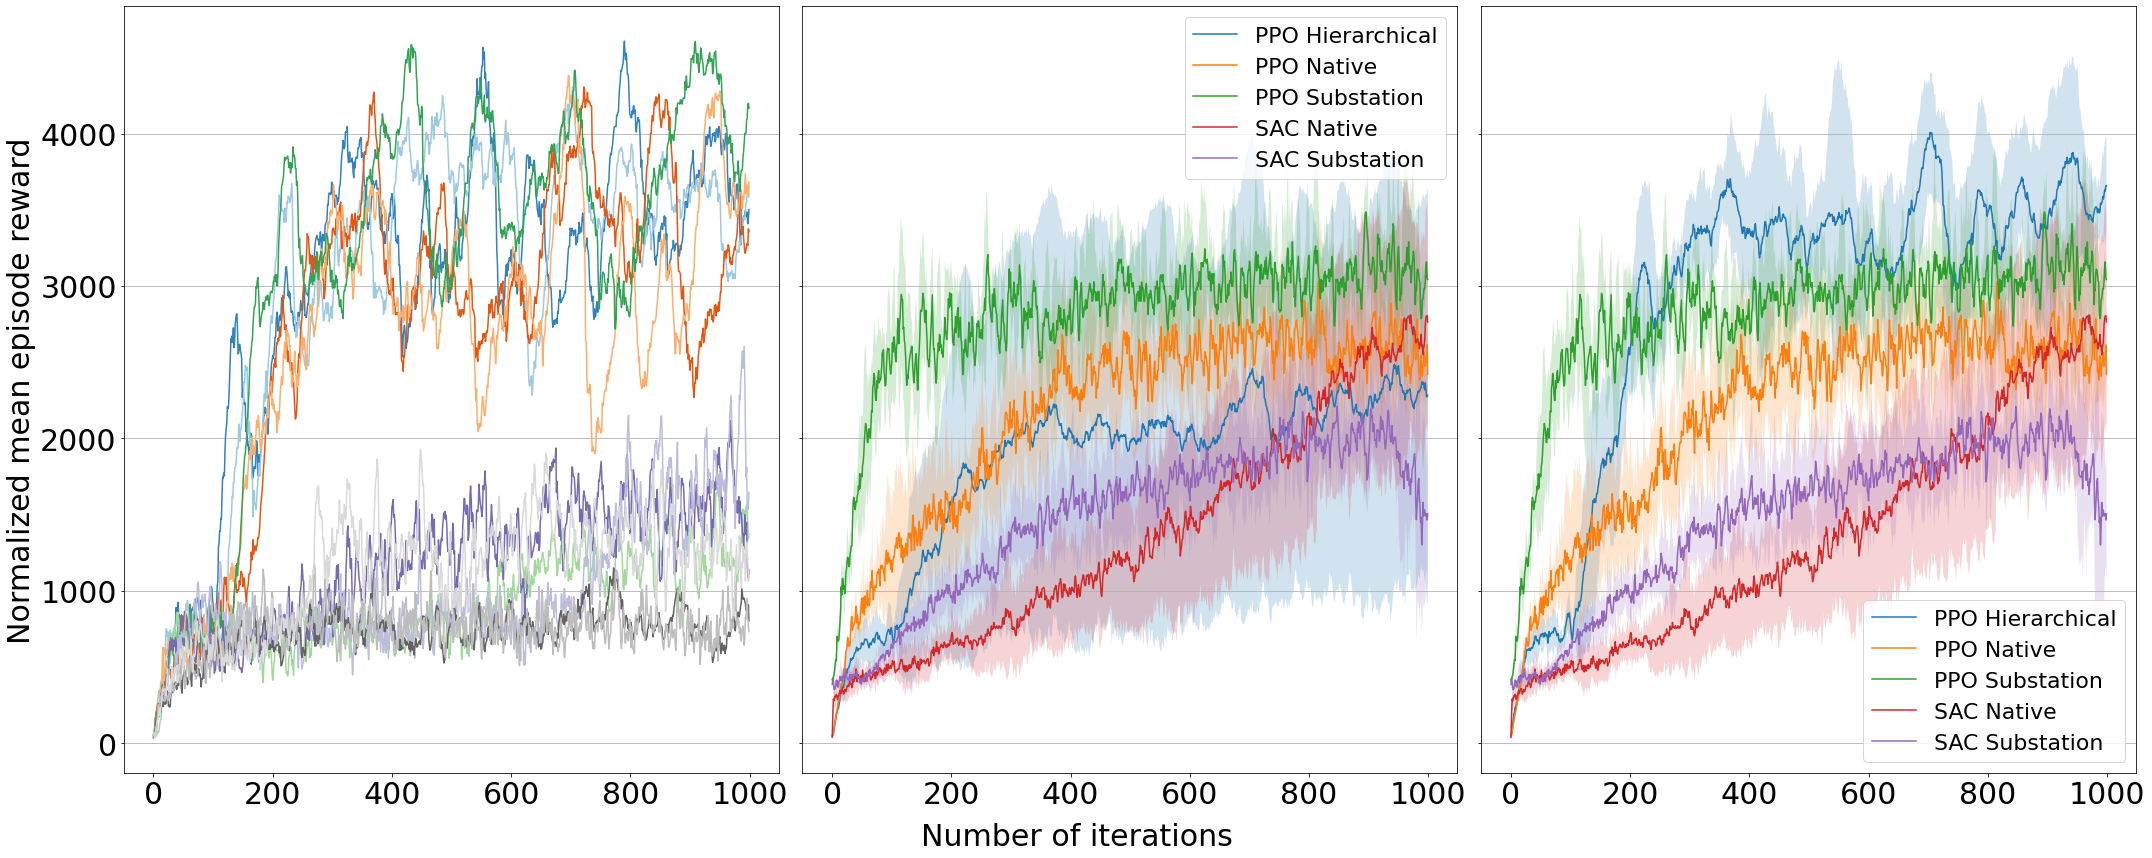

<Figure size 720x576 with 0 Axes>

In [58]:

# Multiplot setting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), tight_layout=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,12), tight_layout=True, sharex=True, sharey=True)

# PLOT 1
df_rewards.loc[df_rewards["type"].isin(["PPO Hierarchical"])].T.iloc[:-1].plot(legend = False, colormap = "tab20c", ax = axes[0]) 

# PLOT 2 

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    axes[1].plot(val.index,val)

axes[1].legend(list(temp_mean.columns), prop = {'size':22})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    axes[1].fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

# PLOT 3

ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

# temp_mean = pd.concat([df_rewards, df_rewards.loc[["PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21"]]]).groupby("type", dropna=False).mean().T
# temp_std = pd.concat([df_rewards, df_rewards.loc[["PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21"]]]).groupby("type", dropna=False).std().T

temp_mean = df_rewards[~mask_for_excluded].groupby("type", dropna=False).mean().T
temp_std = df_rewards[~mask_for_excluded].groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    axes[2].plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

axes[2].legend(list(temp_mean.columns), prop = {'size':22})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    axes[2].fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)


# COMMON SETTINGS FOR ALL PLOTS 

for ax in axes:
    ax.grid(axis = "y")
    ax.tick_params(axis = "x", labelsize=30)
    ax.tick_params(axis = "y", labelsize=30)
    # ax.set_xlabel('Number of iterations', size = 20)
    ax.set_ylabel('Normalized mean episode reward', size = 30)
   
# Set common x axis
# fig.text(0.5, -0.04, 'Number of iterations', ha='center', size = 35)
fig.supxlabel('Number of iterations', size = 30)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel('Number of iterations', size = 20)
# plt.ylabel('Normalized mean episode reward', size = 20)
# plt.grid(axis = "y")
# plt.tight_layout()

fig.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/dichotomy_hierarchical.jpg", dpi = 200)

(1000, 5) (1000, 5)


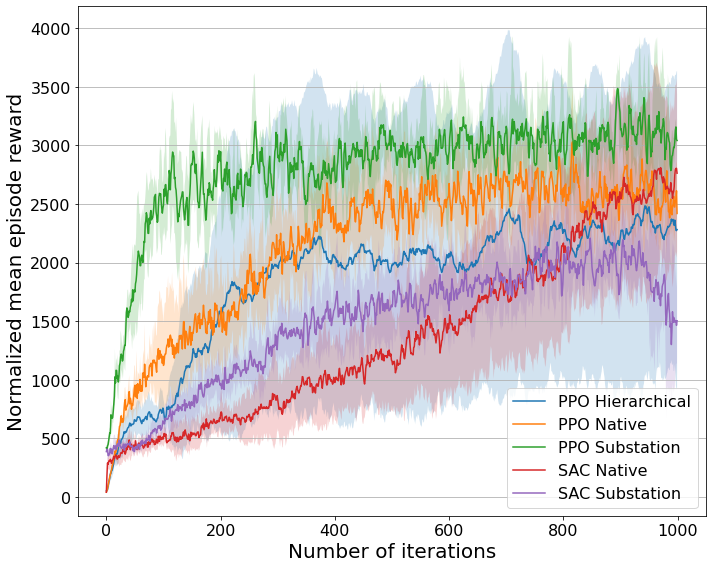

In [227]:
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.legend(list(temp_mean.columns), prop = {'size':16})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of iterations', size = 20)
plt.ylabel('Normalized mean episode reward', size = 20)
# plt.legend(list(temp_mean.columns), prop = {'size':16})
plt.grid(axis = "y")
plt.show()


ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/outages_training_reward_agents.jpg", dpi = 200)

In [214]:
df_eval_steps.loc["PPO_HierarchicalGridGym_07590_00013_13_seed=0_2022-06-18_07-19-56"][:-1].astype(float).sort_values(ascending=False) #.idxmax()

839    5195.060059
709    5122.939941
689    5016.580078
919    4917.709961
499    4831.129883
          ...     
994            NaN
995            NaN
996            NaN
997            NaN
998            NaN
Name: PPO_HierarchicalGridGym_07590_00013_13_seed=0_2022-06-18_07-19-56, Length: 1000, dtype: float64

In [255]:
# df_eval_steps.max(axis=1).sort_values(ascending=False) 

(1000, 4) (1000, 4)


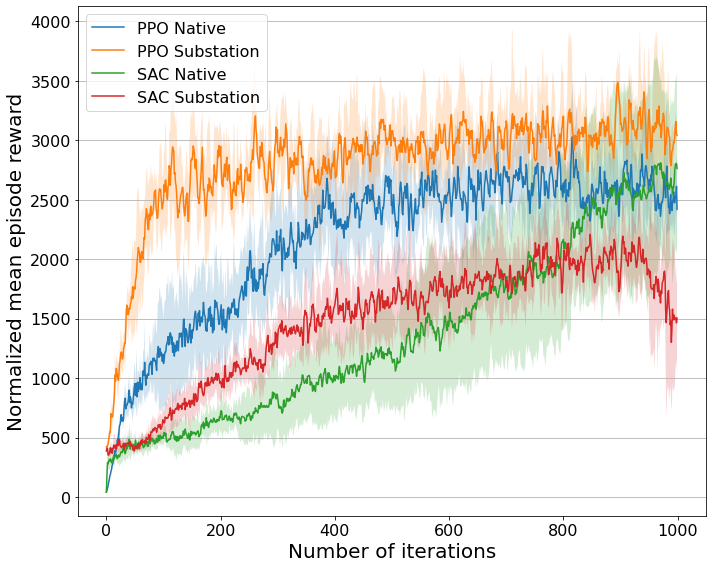

In [10]:
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.legend(list(temp_mean.columns), prop = {'size':16})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of iterations', size = 20)
plt.ylabel('Normalized mean episode reward', size = 20)
# plt.legend(list(temp_mean.columns), prop = {'size':16})
plt.grid(axis = "y")
plt.show()


# ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/outages_training_reward_agents.jpg", dpi = 200)

### Performance analysis

In [220]:
(df["num_topo_actions"]) *  (1/(df["mean_chronic_length"])) 

PPO Substation      2.210510
PPO Native          4.078418
SAC Native          3.613238
SAC Substation      1.282729
Greedy              1.224691
PPO Hierarchical    2.594501
dtype: float64

In [221]:
df.mean_chronic_length

PPO Substation      4052.910
PPO Native          3688.195
SAC Native          4277.880
SAC Substation      2429.195
Greedy               911.250
PPO Hierarchical    5124.685
Name: mean_chronic_length, dtype: float64

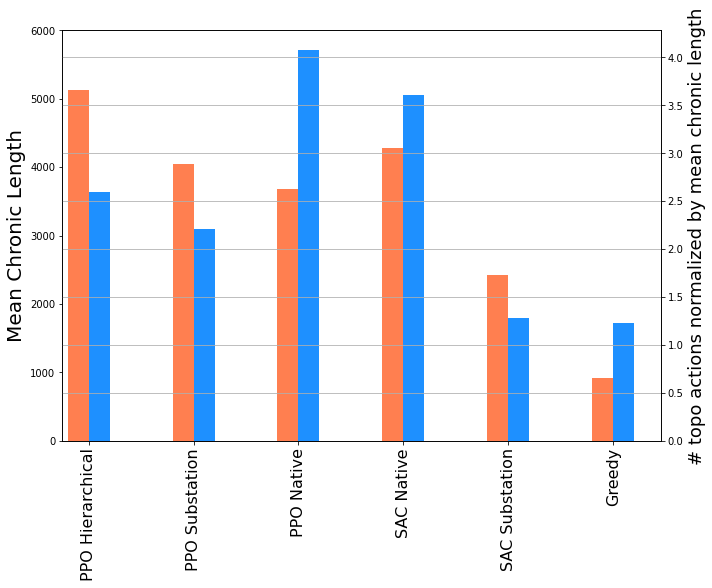

In [231]:
fig = plt.figure(figsize=(10,8), tight_layout=True) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2
colors = sns.color_palette('pastel')

df.mean_chronic_length.plot(kind='bar', color='coral', ax=ax, width=width, position=1)
# (1-df["No Op"]).plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0)
(df.num_topo_actions/(df.mean_chronic_length)).plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0)


ax.set_ylabel('Mean Chronic Length', size = 20)
ax2.set_ylabel('# topo actions normalized by mean chronic length', size = 18)

ax.set_ylim(0, 6000)
# ax2.set_ylim(0, 1)
# ax2.set_ylim(0, df.num_topo_actions.max()*1.1)

ax.set_xticklabels(df.index, fontsize=16)

plt.grid(axis = "y")
plt.show()

# ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/performance_agents_test_split.jpg", dpi = 200)
#plt.savefig()

# cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12, "Implict No op", "Explicit No op"]]
df_op = df[["1", "2","3", "4", "5", "8", "12"]].div(df[["1", "2","3", "4", "5", "8", "12"]].sum(axis=1), axis=0)
cols_this_plot = [str(elem) for elem in [1,2,3,4,5,8,12]]

ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/outages_performance_agents_test_split.jpg", dpi = 200)

#plt.savefig()

-0.30000000000000004
-0.2
-0.1
0.0
0.1
0.2


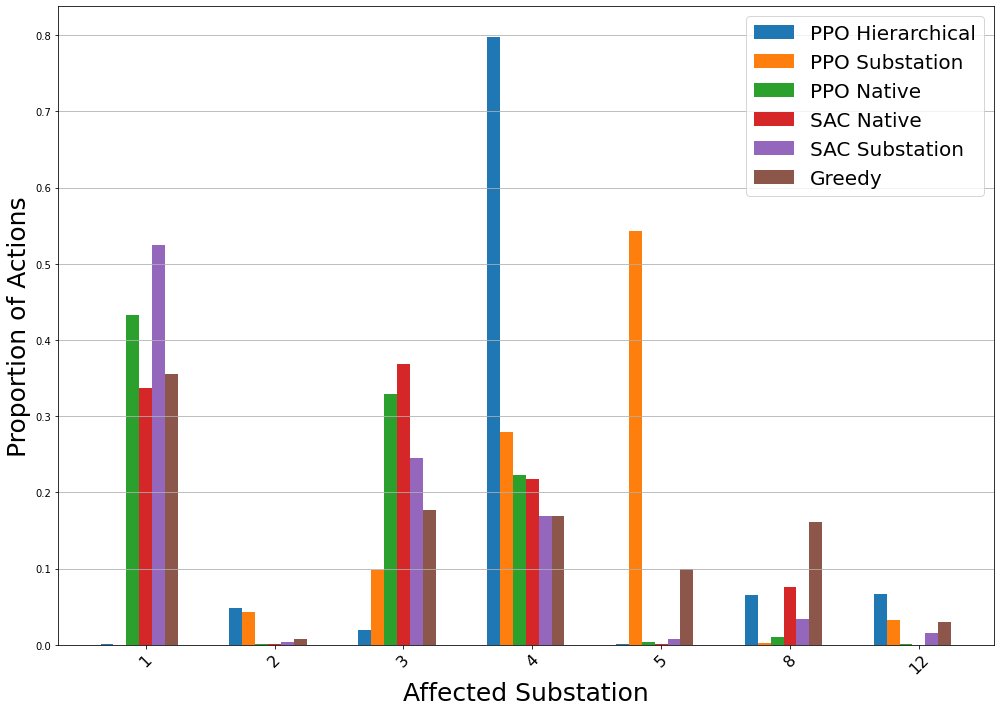

In [232]:
X_axis = np.arange(df_op.loc[df_op.index[0]][cols_this_plot].shape[0])
ax = plt.figure(figsize=(14,10), tight_layout=True)
colors = sns.color_palette('pastel')
offset = 0.1
for i, algo_type in enumerate(df_op.index):
    print((i - len(df_op.index)//2)*offset)
    plt.bar(X_axis + (i - len(df_op.index)//2)*offset , df_op.loc[algo_type][cols_this_plot], 0.1, label = algo_type)
    #plt.bar(X_axis + 0.2, df_op.loc["PPO Substaion"][:-1], 0.4, label = 'PPO Substation')

plt.xticks(X_axis, df_op.loc[df_op.index[0]][cols_this_plot].index, rotation = 45)

plt.xticks(fontsize=16)
plt.xlabel('Affected Substation', size = 25)
plt.ylabel('Proportion of Actions', size = 25)
#plt.title('Behaviours of different agents', size = 24)
plt.legend( prop={'size': 20})
plt.grid(axis = "y")
plt.show()

ax.get_figure().savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/outages_affected_substation_distr_op_test_split.jpg", dpi = 200)

In [230]:
include_cols = [
  ('mean_chronic_length',"Mean chronic length"),
    ("median_chronic_length", "Median chronic length"),
       ('mean_normalized_reward', "Mean normalized reward"),
     ('num_topo_actions', "\# of topo changes"),
        ('num_imperfect_chron', "\# unsolved chronics"),
    ('num_unique_topos', "\# of unique topologies"),
     ('mean_topo_depth', "Mean topo depth"),
      ('std_topo_depth', "St. dev. of topo depth"),
      ('num_unqiue_seq', "\# unique sequences"),
      ("mean_seq_len", "Mean sequence length"),
      ("std_seq_len", "St. dev. of sequence length"),
       ('mean_repeat_seq', "Mean sequence repeatability"),
       ( 'std_repeat_seq', "St. dev. of sequence repeatability"),
         
         ]


df_latex = df[[elem[0] for elem in include_cols]]
df_latex.columns = [elem[1] for elem in include_cols]


table = Texttable(0)
table.set_cols_align(["c"] * (df_latex.shape[0]+1) )
#table.set_deco(Texttable.HEADER | Texttable.BORDER)
table.set_precision(2)

add_rows = [[""] + list(df_latex.T.columns)]
for row in df_latex.T.iterrows():
    add_rows.append([row[0]] + list(row[1])) 

print(add_rows)
table.add_rows(add_rows)


print('Tabulate Table:')
print(tabulate(add_rows, headers='firstrow'))

print('\nTexttable Table:')
print(table.draw())


print('\nTexttable Latebx:')
print(latextable.draw_latex(table, caption="A comparison of rocket features.", label = "table:noOutagesSummaryTable", use_booktabs = False))

[['', 'PPO Hierarchical', 'PPO Substation', 'PPO Native', 'SAC Native', 'SAC Substation', 'Greedy'], ['Mean chronic length', 5124.685, 4052.91, 3688.195, 4277.88, 2429.195, 911.25], ['Median chronic length', 5184.0, 3317.5, 3027.5, 3312.0, 1440.0, 720.0], ['Mean normalized reward', 6948.036273154951, 6927.15269632985, 6940.006815070679, 6948.994785897783, 6922.362231029944, 6916.644798479696], ['\\# of topo changes', 13295.999999999998, 8959.000000000002, 15042.0, 15456.999999999998, 3116.0000000000005, 1116.0000000000002], ['\\# unsolved chronics', 132.0, 156.0, 174.0, 152.0, 195.0, 200.0], ['\\# of unique topologies', 41.0, 141.0, 169.0, 83.0, 219.0, 308.0], ['Mean topo depth', 4.808736315934586, 4.1581693767737, 4.492868959251084, 4.049934617497936, 4.328382995258818, 3.3965904015661685], ['St. dev. of topo depth', 0.6823490732588616, 0.9271920961921669, 0.8699414428184953, 0.7935401323216041, 1.2229824770850628, 1.6871573468060523], ['\\# unique sequences', 404.0, 273.0, 1173.0, 85

### Double check results for hierarchical

In [61]:
actions = np.load("evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_test_chronics/actions.npy", allow_pickle=True).item()
avg_time_per_step = np.load("evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_test_chronics/avg_time_per_step.npy", allow_pickle=True).item()
chronic_to_num_steps = np.load("evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_test_chronics/chronic_to_num_steps.npy", allow_pickle=True).item()
topo_vects = np.load("evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_test_chronics/topo_vects.npy", allow_pickle=True).item()

In [114]:

all_topos = np.concatenate(list(topo_vects.values()))
unique_topos, topo_count = np.unique(all_topos, axis=0, return_counts=True)
# Filter out the disconnected lines 
#unique_topos = unique_topos[(unique_topos>=1).all(axis=1)]


In [138]:
everything_disconnected_mask = (unique_topos>=1).any(axis=1) # filter everything disconneced
appear_more_than_once_mask = topo_count > 1

# valid_topos = unique_topos[everything_disconnected_mask]
# valid_topos = valid_topos[appear_more_than_once_mask]


# valid_topos = unique_topos[appear_once_mask | everything_disconnected_mask]
valid_topos.shape


In [157]:
for ix, elem in enumerate(chronic_to_num_steps[1]):
    print(ix, elem)

0 2
1 3
2 518
3 865
4 938
5 939
6 1094
7 1098
8 1298
9 1300
10 1306
11 1729
12 1860
13 1956
14 2305
15 2306
16 2307
17 2388
18 2737
19 2738
20 2739
21 2740
22 2741
23 2742
24 2743
25 2744
26 2745
27 2746
28 2747
29 2748
30 2749
31 2751
32 2752
33 2785
34 2825
35 2881
36 2956
37 2974
38 4721
39 4722
40 4723
41 4897
42 4898
43 4899
44 4900
45 4901
46 4902
47 5008
48 5010
49 5041
50 5042
51 5043
52 5044
53 5045
54 5050
55 5053
56 5054
57 5055
58 5068
59 5070
60 5126
61 5127
62 5128
63 5129
64 5130
65 5131
66 5132
67 5133
68 5134
69 5135
70 5136
71 5137
72 5138
73 5139
74 5140
75 5329
76 5330
77 5331
78 5332
79 5333
80 5593
81 6481
82 6482
83 6483
84 6484
85 6485
86 6486
87 6487
88 6488
89 6489
90 6490
91 6491
92 6492
93 6493
94 6494
95 6495
96 6496
97 6497
98 6498
99 6499
100 6500
101 6529
102 6568
103 6769
104 6856
105 6857
106 6858
107 6859
108 6860
109 6863
110 6864
111 6913
112 6976
113 7057
114 7058
115 7059
116 7060
117 7061
118 7062
119 7063
120 7064
121 7065
122 7067
123 7068
124 

In [191]:
chronic_id = 0
n1 = 5
n2 = 6
change_ix = np.argwhere(np.abs(topo_vects[chronic_id][n1] - topo_vects[chronic_id][n2])>0).flatten()

In [192]:
topo_vects[chronic_id][n1][change_ix], topo_vects[0][n2][change_ix]

(array([2, 1], dtype=int32), array([1, 2], dtype=int32))

In [193]:
topo_vects[chronic_id][n1], topo_vects[chronic_id][n2]

(array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  2,
         2,  1,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
         1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1], dtype=int32),
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  2,
         2,  1,  1,  2,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
         1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1], dtype=int32))

### Train and val set perfroamnce

In [38]:
# EVAL_PATHS = {
#                 "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_test_chronics", "07590_00015"),
#                 "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_Greedy_29991_00005_5_num_sgd_iter=15,seed=32_2022-04-11_22-04-26/750_test_chronics", "29991_00005"),
#                  "PPO Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/760_test_chronics", "8ae06_00002"), 
#                 "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_9862f_00000_0_seed=21_2022-04-11_22-04-29/850_test_chronics", "9862f_00000" ),
#                 "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_Greedy_38688_00005_5_seed=33_2022-04-14_13-32-02/600_test_chronics", "38688_00005"),
#                 "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/None_test_chronics", "8ae06_00002"),
# }

EVAL_PATHS = {
                 "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00013_13_seed=0_2022-06-18_07-19-56/840_test_chronics", "07590_00013"),
                # "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_test_chronics", "07590_00015"),
                "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_Greedy_29991_00005_5_num_sgd_iter=15,seed=32_2022-04-11_22-04-26/750_test_chronics", "29991_00005"),
                 "PPO Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/760_test_chronics", "8ae06_00002"), 
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_9862f_00000_0_seed=21_2022-04-11_22-04-29/850_test_chronics", "9862f_00000" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_Greedy_38688_00005_5_seed=33_2022-04-14_13-32-02/600_test_chronics", "38688_00005"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/None_test_chronics", "8ae06_00002"),
}

In [56]:
# Eval paths for models trained with train/val/test split
EVAL_PATHS_TRAIN = {
                 "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00013_13_seed=0_2022-06-18_07-19-56/840_train_chronics", "07590_00013"),
        #    "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_train_chronics", "07590_00015"),
                 "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_Greedy_29991_00005_5_num_sgd_iter=15,seed=32_2022-04-11_22-04-26/750_train_chronics", "29991_00005"),
                 "PPO Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/760_train_chronics", "8ae06_00002"), 
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_9862f_00000_0_seed=21_2022-04-11_22-04-29/850_train_chronics", "9862f_00000" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_Greedy_38688_00005_5_seed=33_2022-04-14_13-32-02/600_train_chronics", "38688_00005"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/None_train_chronics", "8ae06_00002"),

}

EVAL_PATHS_VAL = {
     "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00013_13_seed=0_2022-06-18_07-19-56/840_val_chronics", "07590_00013"),
    #  "PPO Hierarchical": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_HierarchicalGridGym_07590_00015_15_seed=10_2022-06-18_17-08-33/990_val_chronics", "07590_00015"),
     "PPO Substation": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_Greedy_29991_00005_5_num_sgd_iter=15,seed=32_2022-04-11_22-04-26/750_val_chronics", "29991_00005"),
                 "PPO Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/760_val_chronics", "8ae06_00002"), 
                "SAC Native" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_9862f_00000_0_seed=21_2022-04-11_22-04-29/850_val_chronics", "9862f_00000" ),
                "SAC Substation" : ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/with_opponent_SAC_Grid_Gym_Greedy_38688_00005_5_seed=33_2022-04-14_13-32-02/600_val_chronics", "38688_00005"),
                "Greedy": ("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/eval_results/greedy_with_opponent_PPO_Grid_Gym_8ae06_00002_2_seed=42_2022-04-08_14-58-44/None_val_chronics", "8ae06_00002")
}

data_per_algorithm_train = {} 
data_per_algorithm_val = {}


for name, path in EVAL_PATHS_TRAIN.items():
    if name not in data_per_algorithm_train:
        if isinstance(path, tuple):
            path, wandb_run_id = path
        else: 
            wandb_run_id = None
        print(f"Processing name {name} ")
        data_per_algorithm_train[name] = {} 
        agent_info, action_analysis, topo_vects, rewards, avg_time_per_step = get_analysis_objects(path,wandb_run_id )
        data_per_algorithm_train[name]["agent_info"] = agent_info
        data_per_algorithm_train[name]["action_analysis"] = action_analysis
    else:
        continue

for name, path in EVAL_PATHS_VAL.items():
    if name not in data_per_algorithm_val:
        if isinstance(path, tuple):
            path, wandb_run_id = path
        else: 
            wandb_run_id = None
        print(f"Processing name {name} ")
        data_per_algorithm_val[name] = {} 
        agent_info, action_analysis, topo_vects, rewards, avg_time_per_step = get_analysis_objects(path,wandb_run_id )
        data_per_algorithm_val[name]["agent_info"] = agent_info
        data_per_algorithm_val[name]["action_analysis"] = action_analysis
    else:
        continue

    

Processing name PPO Hierarchical 
ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Native 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Native 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name Greedy 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Hierarchical 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name PPO Native 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Native 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name SAC Substation 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
Processing name Greedy 


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


ENV NAME rte_case14_realistic_train
The environment has 700 chronics.


Exception ignored in: <function GymEnv.__del__ at 0x7f8a8b531950>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'


In [57]:
for name in EVAL_PATHS_TRAIN.keys():
    train_mean = data_per_algorithm_train[name]["agent_info"].mean_chronic_length
    val_mean = data_per_algorithm_val[name]["agent_info"].mean_chronic_length
    test_mean = data_per_algorithm[name]["agent_info"].mean_chronic_length

    # train_mean = data_per_algorithm_train[name]["agent_info"].quantile_chronic_length(0.5)
    # val_mean = data_per_algorithm_val[name]["agent_info"].quantile_chronic_length(0.5)
    # test_mean = data_per_algorithm[name]["agent_info"].quantile_chronic_length(0.5)
    print("Model", name)
    print("Train mean: ", train_mean)
    print("Val mean: ", val_mean)
    print("Test mean: ", test_mean)

    print(f"Weighted average is {0.7*train_mean + 0.2*val_mean + 0.1*test_mean}")
    print("-"*50)

Model PPO Hierarchical
Train mean:  5289.402857142857
Val mean:  4663.06
Test mean:  5124.685
Weighted average is 5147.662499999999
--------------------------------------------------
Model PPO Substation
Train mean:  4185.25
Val mean:  4171.64
Test mean:  4052.91
Weighted average is 4169.294
--------------------------------------------------
Model PPO Native
Train mean:  4126.744285714286
Val mean:  3985.16
Test mean:  3688.195
Weighted average is 4054.5725
--------------------------------------------------
Model SAC Native
Train mean:  4550.225714285714
Val mean:  4183.18
Test mean:  4277.88
Weighted average is 4449.582
--------------------------------------------------
Model SAC Substation
Train mean:  2806.3171428571427
Val mean:  2457.23
Test mean:  2429.195
Weighted average is 2698.7875
--------------------------------------------------
Model Greedy
Train mean:  957.9642857142857
Val mean:  942.31
Test mean:  911.25
Weighted average is 950.1619999999999
---------------------------

In [52]:
EVAL_PATHS_TRAIN.keys()

dict_keys(['PPO Hierarchical', 'PPO Native', 'SAC Native', 'SAC Substation', 'Greedy'])

In [58]:
# Median calculation

for name in EVAL_PATHS_TRAIN.keys():
    train_median = [steps[-1] for chronic,steps in data_per_algorithm_train[name]['agent_info'].chronic_to_num.items()]
    val_median = [steps[-1] for chronic,steps in data_per_algorithm_val[name]['agent_info'].chronic_to_num.items()]
    test_median = [steps[-1] for chronic,steps in data_per_algorithm[name]['agent_info'].chronic_to_num.items()]


    print("Model", name)
    print("Train median: ", np.quantile(train_median, 0.5))
    print("Val median: ", np.quantile(val_median, 0.5))
    print("Test median: ", np.quantile(test_median, 0.5))


    print(f"Overall median is {np.quantile(train_median + val_median + test_median, 0.5)}")
    print("-"*50)

Model PPO Hierarchical
Train median:  5324.0
Val median:  4605.5
Test median:  5184.0
Overall median is 5242.5
--------------------------------------------------
Model PPO Substation
Train median:  3600.0
Val median:  3294.5
Test median:  3317.5
Overall median is 3402.5
--------------------------------------------------
Model PPO Native
Train median:  3316.0
Val median:  3280.5
Test median:  3027.5
Overall median is 3294.0
--------------------------------------------------
Model SAC Native
Train median:  4467.5
Val median:  3301.0
Test median:  3312.0
Overall median is 3744.0
--------------------------------------------------
Model SAC Substation
Train median:  2016.0
Val median:  1584.0
Test median:  1440.0
Overall median is 1872.0
--------------------------------------------------
Model Greedy
Train median:  720.0
Val median:  817.0
Test median:  720.0
Overall median is 720.0
--------------------------------------------------


## Fully hierarchical agent with outgages

### Obtaining reward plots from Tensorboard

Sometimes Wandb just stops with logging even though the trial progresses.
Fortunately the logs are still saved in Tensorboard.

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def make_df(out_func, use_keys):
    """
    Small utility function to fix the dataframe creation in the function below.
    """
    out = {}

    for key, val in out_func.items():
        if key in use_keys:
            # out[key] = np.array(val).flatten() # this ignores "steps"
            out[key] = {key:val["value"] for key, val in val.to_dict().items()}

    return pd.DataFrame.from_dict(out)
    

def tabulate_events(dpath, use_keys = [ 'ray/tune/episode_reward_mean', 'ray/tune/evaluation/episode_reward_mean',\
                                          'ray/tune/custom_metrics/num_env_steps_mean', 'ray/tune/evaluation/custom_metrics/num_env_steps_mean']):

    final_out = {}
    for dname in os.listdir(dpath):
        if ".DS_Store" in dname:
            continue
        print(f"Converting run {dname}",end="")
        ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
        tags = ea.Tags()['scalars']

        out = {}

        for tag in tags:
            if tag not in use_keys:
                continue 
            tag_values=[]
            wall_time=[]
            steps=[]

            for event in ea.Scalars(tag):
               # print(event)
                tag_values.append(event.value)
                wall_time.append(event.wall_time)
                steps.append(event.step)

            # out[tag]=pd.DataFrame(data=dict(zip(steps,np.array([tag_values,wall_time]).transpose())), columns=steps,index=['value','wall_time'])
            out[tag]=pd.DataFrame(data=dict(zip(steps,np.array(tag_values))), index = ["value"], columns=steps)

        if len(tags)>0:  
            df = pd.DataFrame() 
            try:
                df = make_df(out, use_keys)
                print("- Done")
                # return out 
            except Exception as e:
                print(f"\n{e}")
                print("- Failed")
                # return out
                continue
        else:
            print('- Not scalers to write')
            continue

        final_out[dname] = df

    return final_out

# path = "youre/path/here"
# paths = ["/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_in_env_outages/PPO_Grid_Gym_8ae06",
#             "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_mlp_substation_outages/PPO_Grid_Gym_Greedy_61b75",
#             "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_in_env_outages/SAC_Grid_Gym_61abb",
#             "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/SAC_greedy_substation_outages/SAC_Grid_Gym_Greedy_0803d"
#             ]

# Paths with 1000 iterations

paths = [
    # "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_fa356/",
    "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_6f11c/"
    ]            
# steps_good = tabulate_events(path)
dft = pd.DataFrame()
for path in paths:
    steps = tabulate_events(path)
    dft =  pd.concat([dft, pd.concat(steps.values(),keys=steps.keys()).reset_index()])

Converting run PPO_HierarchicalGridGym_6f11c_00005_5_num_sgd_iter=10,seed=32_2022-06-13_12-00-02- Done
Converting run PPO_HierarchicalGridGym_6f11c_00007_7_num_sgd_iter=5,seed=28_2022-06-14_03-58-11- Done
Converting run PPO_HierarchicalGridGym_6f11c_00004_4_num_sgd_iter=10,seed=50_2022-06-13_11-59-48- Done
Converting run PPO_HierarchicalGridGym_6f11c_00006_6_num_sgd_iter=5,seed=42_2022-06-14_03-46-20- Done
Converting run PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21- Done
Converting run PPO_HierarchicalGridGym_6f11c_00008_8_num_sgd_iter=10,seed=23_2022-06-14_05-49-40- Done
Converting run PPO_HierarchicalGridGym_6f11c_00000_0_num_sgd_iter=5,seed=21_2022-06-13_11-58-54- Done
Converting run PPO_HierarchicalGridGym_6f11c_00003_3_num_sgd_iter=5,seed=33_2022-06-13_11-59-34- Done
Converting run PPO_HierarchicalGridGym_6f11c_00009_9_num_sgd_iter=5,seed=38_2022-06-14_08-39-34- Not scalers to write
Converting run PPO_HierarchicalGridGym_6f11c_00001_1_num_sgd_i

In [37]:
df_unprocessed = dft #pd.concat(steps.values(),keys=steps.keys()).reset_index().loc[:, ["level_0", "level_1", "ray/tune/episode_reward_mean"]]#set_index(["level_1"])
runs = np.unique(df_unprocessed.level_0)

name_list, episode_reward_mean, evaluation_num_steps, training_num_steps = [], [], [], []
for run in runs: 

    name_list.append(run)
    episode_reward_mean.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/episode_reward_mean"]))
    evaluation_num_steps.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/evaluation/custom_metrics/num_env_steps_mean"]))
   # training_num_steps.append(list(df_unprocessed.loc[df_unprocessed["level_0"] == run ,"ray/tune/custom_metrics/num_env_steps_mean"]))

runs_dict = {
    "name": name_list,
    "episode_reward_mean":episode_reward_mean
    }

def process_wandb_name(name):
    name_lst = name.split("_")
    algo_type = name_lst[0].split("_")[0]
    # print(name_lst)
    if name_lst[1] == "HierarchicalGridGym":
        is_greedy = "Hierarchical"
    else:
        is_greedy = "Substation" if name_lst[3] == "Greedy" else "Native"
     
    return f"{algo_type} {is_greedy}" 
      
df_rewards = pd.DataFrame(runs_dict["episode_reward_mean"], index=runs_dict["name"])#.head()
df_eval_steps = pd.DataFrame(evaluation_num_steps, index=runs_dict["name"])#.head()

# Add types: PPO/SAC Native/Greedy
df_rewards["type"] = list(pd.Series(df_rewards.index).apply(lambda name:process_wandb_name(name) ))
df_eval_steps["type"] = list(pd.Series(df_eval_steps.index).apply(lambda name:process_wandb_name(name) ))

df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["SAC Native", "SAC Substation"]) ,df_rewards.columns[:-1]] / 3

df_rewards.loc[df_rewards["type"].isin(["PPO Hierarchical"]) ,df_rewards.columns[:-1]] = df_rewards.loc[df_rewards["type"].isin(["PPO Hierarchical"]) ,df_rewards.columns[:-1]] / 2

In [38]:
df_eval_steps.max(axis=1).sort_values(ascending=False)

/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21    5141.919922
PPO_HierarchicalGridGym_6f11c_00004_4_num_sgd_iter=10,seed=50_2022-06-13_11-59-48    2665.520020
PPO_HierarchicalGridGym_6f11c_00003_3_num_sgd_iter=5,seed=33_2022-06-13_11-59-34     2436.239990
PPO_HierarchicalGridGym_6f11c_00001_1_num_sgd_iter=5,seed=42_2022-06-13_11-59-07     2023.949951
PPO_HierarchicalGridGym_6f11c_00000_0_num_sgd_iter=5,seed=21_2022-06-13_11-58-54     1798.060059
PPO_HierarchicalGridGym_6f11c_00005_5_num_sgd_iter=10,seed=32_2022-06-13_12-00-02    1404.829956
PPO_HierarchicalGridGym_6f11c_00006_6_num_sgd_iter=5,seed=42_2022-06-14_03-46-20     1349.880005
PPO_HierarchicalGridGym_6f11c_00007_7_num_sgd_iter=5,seed=28_2022-06-14_03-58-11     1159.530029
PPO_HierarchicalGridGym_6f11c_00008_8_num_sgd_iter=10,seed=23_2022-06-14_05-49-40     857.289978
dtype: float64

In [28]:
df_eval_steps.max(axis=1).sort_values(ascending=False)

/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


PPO_HierarchicalGridGym_fa356_00005_5_clip_param=0.3,entropy_coeff=0.03,kl_coeff=0.3,lr=0.001,num_sgd_iter=5,seed=49_2022-06-10_14-44-58       5446.779785
PPO_HierarchicalGridGym_fa356_00011_11_clip_param=0.3,entropy_coeff=0.02,kl_coeff=0.0,lr=0.0001,num_sgd_iter=15,seed=21_2022-06-11_04-37-03    5235.089844
PPO_HierarchicalGridGym_fa356_00006_6_clip_param=0.3,entropy_coeff=0.01,kl_coeff=0.0,lr=0.001,num_sgd_iter=15,seed=23_2022-06-10_20-02-30      3288.659912
PPO_HierarchicalGridGym_fa356_00001_1_clip_param=0.3,entropy_coeff=0.02,kl_coeff=0.3,lr=0.0001,num_sgd_iter=10,seed=33_2022-06-10_14-44-03     3195.419922
PPO_HierarchicalGridGym_fa356_00002_2_clip_param=0.2,entropy_coeff=0.03,kl_coeff=0.0,lr=0.001,num_sgd_iter=10,seed=37_2022-06-10_14-44-16      2339.820068
PPO_HierarchicalGridGym_fa356_00000_0_clip_param=0.2,entropy_coeff=0.02,kl_coeff=0.3,lr=0.0001,num_sgd_iter=5,seed=21_2022-06-10_14-43-50      1556.180054
PPO_HierarchicalGridGym_fa356_00012_12_clip_param=0.2,entropy_coeff=0.

#### Find the checkpoint with the highest number of steps on validation set

In [39]:
agent_type_to_log_file = {"PPO Native": "PPO_in_env_outages",
                          "PPO Substation": "PPO_mlp_substation_outages",
                          "SAC Native": "SAC_in_env_outages",
                          "SAC Substation": "SAC_greedy_substation_outages",
                          "PPO Hierarchical": "PPO_full_hier_mlp_outages_share_critic",
                        #   "PPO Hierarchical Centralized":"PPO_full_hier_mlp_outages_central_critic"
                          }


max_num_steps = df_eval_steps.groupby("type", dropna=False).agg("max").idxmax(axis = 1)

for type, col in zip(max_num_steps.index, max_num_steps):
    col = col#[0] # discard the "max" from groupby
    print("Agent type", type)
    print("Checkpoint number is: ", col + 1)
    temp_df = df_eval_steps.loc[df_eval_steps["type"] == type, col]
    model_name = temp_df.idxmax()
    best_checkpoint = temp_df.max() + 1

    print("Best number of evaluation steps: ", best_checkpoint)
    print("Model name", model_name)
    

    agent_type = type.split(" ")[0].lower()
    run_name = model_name.split("000")[0].strip("_")
    checkpoint_path = f" /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/{agent_type_to_log_file[type]}/{run_name}/{model_name}"
    checkpoint_num = col + 1

    eval_command = f"python evaluation/run_eval.py --agent_type {agent_type} --checkpoint_path {checkpoint_path} --checkpoint_num {checkpoint_num} --use_split test"
    
    print("Evaluation command is: \n", eval_command)

    print("-"*40)
    print("\n")

Agent type PPO Hierarchical
Checkpoint number is:  900
Best number of evaluation steps:  5142.919921875
Model name PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21
Evaluation command is: 
 python evaluation/run_eval.py --agent_type ppo --checkpoint_path  /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_6f11c/PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21 --checkpoint_num 900 --use_split test
----------------------------------------




(1000, 1) (1000, 1)


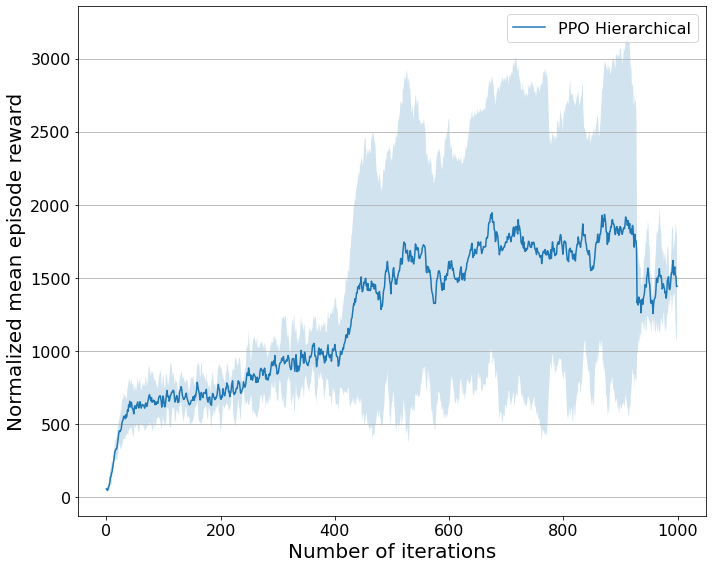

In [40]:
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.legend(list(temp_mean.columns), prop = {'size':16})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of iterations', size = 20)
plt.ylabel('Normalized mean episode reward', size = 20)
# plt.legend(list(temp_mean.columns), prop = {'size':16})
plt.grid(axis = "y")
plt.show()


# ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/outages_training_reward_agents.jpg", dpi = 200)

(847, 1) (847, 1)


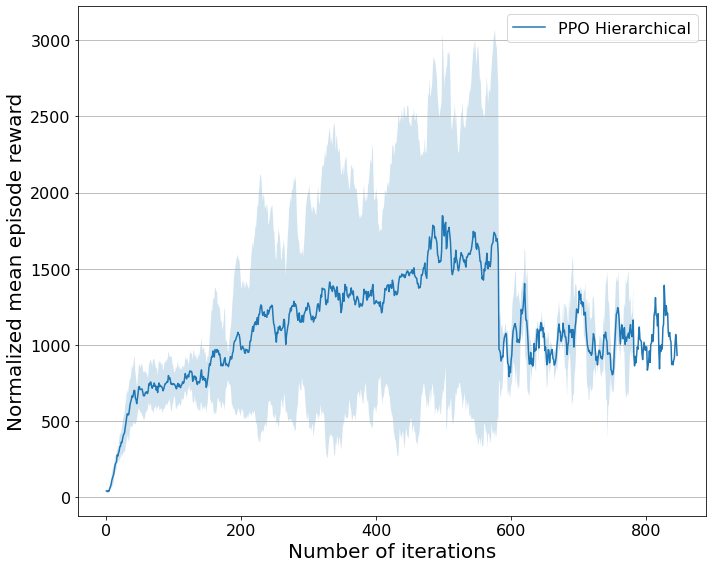

In [64]:
ax = plt.figure(figsize=(10,8), tight_layout=True)
colors = sns.color_palette('pastel')

temp_mean = df_rewards.groupby("type", dropna=False).mean().T
temp_std = df_rewards.groupby("type", dropna=False).std().T

print(temp_mean.shape, temp_std.shape)
for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    # plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.legend(list(temp_mean.columns), prop = {'size':16})

for col in temp_mean.columns:
    val = temp_mean[col]
    val_std = temp_std[col]
    # plt.plot(val.index,val)
    # ax.plot(val_std.index,val_std+val)
    plt.fill_between(val_std.index, abs(val_std+val), abs(val_std-val), alpha=0.2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of iterations', size = 20)
plt.ylabel('Normalized mean episode reward', size = 20)
# plt.legend(list(temp_mean.columns), prop = {'size':16})
plt.grid(axis = "y")
plt.show()


# ax.savefig("/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/figures/outages_training_reward_agents.jpg", dpi = 200)

### Multi agent restore

In [9]:
import logging
import re 
import json
import os
import logging

from ray.rllib.agents import ppo, sac # import the type of agents
from grid2op_env.grid_to_gym import Grid_Gym, HierarchicalGridGym
from typing import Tuple, Union, Optional

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# def restore_agent(trainer_type:str, path:str, checkpoint_num:Optional[int] = None,
#                  modify_keys: Optional[dict] = None, ) \
#                         -> Tuple[Union[ppo.PPOTrainer, sac.SACTrainer], dict]:
#     """
#     Function that restores the agent from tune checkpointwith 
#     correct hyperparameters.
    
#     Keyword arguments:
#     ----------
#     trainer_type: str 
#         Type of trainer to use. "ppo" and "sac" are supported.
#     path: str
#         Path that contains (1) the params.json and 
#         (2) folders that contain checkpoints. Note that
#         default tune naming scheme is assumed for (2), i.e.
#         checkpoint_<0..0checkpoint_num> that contains files
#         checkpoint-<checkpoint_num> and checkpoint-<checkpoint_num>.tune_metadata  
#     checkpoint_num: int (Optional)
#         What checkpoint number to restore. If None,
#         the checkpoint with the highest number is restored.
#     modify_keys: dict (Optional)
#         Keys to add/change in the config.
    
#     Returns:
#     --------
#     agent: rllib agent
#         Agent restored from the checkpoint.
#     env_config: dict
#         Env config if return_env_config is True.


#     Example usage:
#     ----------
#     agent, env_config = restore_agent(path = "/Users/blazejmanczak/Desktop/try_this/PPO_Grid_Gym_e07fb_00004_4_clip_param=0.2,lambda=0.94,lr=0.001,vf_loss_coeff=0.9_2021-12-04_03-59-36",
#                    checkpoint_num = 900,
#                    modify_keys={"env_config": {"scale": True}})

#     rllib_env = Grid_Gym(env_config);
#     """

from ray.rllib.agents.ppo.ppo_torch_policy import PPOTorchPolicy
import gym

trainer_type = "ppo"
path = "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_6f11c/PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21"
checkpoint_num = 900
modify_keys = None


from ray.rllib.agents.ppo.ppo_torch_policy import PPOTorchPolicy
import gym
from gym.spaces import Discrete, Box
import numpy as np

from ray.rllib.models import ModelCatalog
from models.mlp import SimpleMlp, ChooseSubstationModel, ChooseActionModel

ModelCatalog.register_custom_model("choose_substation_model", ChooseSubstationModel)
ModelCatalog.register_custom_model("choose_action_model", ChooseActionModel)

config_params = json.load(open(os.path.join(path, "params.json")))
config_params.pop("callbacks", None)


grid_gym = Grid_Gym(config_params["env_config"])
    
def policy_mapping_fn(agent_id, episode, worker, **kwargs):
    if agent_id.startswith("choose_action"):
        return "choose_action_agent"
    else:
        return "choose_substation_agent"

### Fixed params
config_params["multiagent"]["policies"]["choose_substation_agent"] = (
    PPOTorchPolicy,
    # grid_gym.observation_space,
    gym.spaces.Dict({
        "regular_obs": grid_gym.observation_space,
        "chosen_action": Discrete(grid_gym.action_space.n),
    }) ,
    Discrete(8),
    config_params["multiagent"]["policies"]["choose_substation_agent"][3]
    
)

config_params["multiagent"]["policies"]["choose_action_agent"] = (
    PPOTorchPolicy,
    gym.spaces.Dict({
        "action_mask":Box(0, 1, shape=(grid_gym.action_space.n, ), dtype=np.float32),
        "regular_obs": grid_gym.observation_space,
        "chosen_substation": Discrete(8)
    }) ,
    grid_gym.action_space,
    config_params["multiagent"]["policies"]["choose_action_agent"][3]
)

config_params["multiagent"]["policy_mapping_fn"] = policy_mapping_fn


# Optionally modify the keys 
if modify_keys is not None:
    for key, val in modify_keys.items():
        if type(val) == dict:
            for key2, val2 in val.items():
                logging.warning(f"Changing config for key {key}[{key2}] from {config_params[key][key2]} to {val2}")
                config_params[key][key2] = val2
                print(f"Changing config {key}[{key2}] to {val2}")
        else:
            logging.warning(f"Changing config for key {key} from {config_params.get(key, None)} to {val}")
            config_params[key] = val
            
env_config = config_params["env_config"]

# Get the checkpoint path with the highest number
checkpoint_paths= os.listdir(path)
if checkpoint_num is None: # get the highest checkpoint number
    checkpoint_num = max([int(re.search(r"checkpoint_0*(\d+)", checkpoint_paths[i]).group(1)) \
                        for i in range(len(checkpoint_paths)) if checkpoint_paths[i][0:10]=="checkpoint"])

checkpoint_path = os.path.join(path,f"checkpoint_{str(0)*(6-len(str(checkpoint_num)))}{checkpoint_num}", \
                    f"checkpoint-{checkpoint_num}")

logger.info(f"Restoring checkpoint {checkpoint_num} from {checkpoint_path}")

if trainer_type == "ppo":
    agent = ppo.PPOTrainer(env=HierarchicalGridGym,
        config = config_params)
        
agent.restore(checkpoint_path);




ENV NAME rte_case14_realistic_train


Exception ignored in: <function GymEnv.__del__ at 0x7f8281fe74d0>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 84, in __del__
    self.close()
  File "/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/grid2op/gym_compat/gymenv.py", line 72, in close
    self.action_space.close()
AttributeError: 'CustomDiscreteActions' object has no attribute 'close'
INFO:__main__:Restoring checkpoint 900 from /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_6f11c/PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21/checkpoint_000900/checkpoint-900
2022-06-17 12:22:27,093	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-06-17 12:22:27,093	INFO ppo.py:167 -

The environment has 700 chronics.
(RolloutWorker pid=61373) ENV NAME rte_case14_realistic_train
(RolloutWorker pid=61369) ENV NAME rte_case14_realistic_train


(RolloutWorker pid=61369) 2022-06-17 12:22:32,051	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=61373) 2022-06-17 12:22:32,052	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
2022-06-17 12:22:32,131	INFO worker_set.py:104 -- Inferred observation/action spaces from remote worker (local worker has no env): {'choose_substation_agent': (Dict(chosen_action:Discrete(106), regular_obs:Dict(gen_p:Box([-0.0514     -0.03855    -0.11014286 -0.1542     -0.0257    ], [1.0514    1.0385499 1.1101428 1.1542    1.0257001], (5,), float32), load_p:Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float32), p_ex:Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf], (20,), float32), p_or:Box([-inf -inf -inf -inf -inf -inf -inf -

(RolloutWorker pid=61373) The environment has 700 chronics.
(RolloutWorker pid=61369) The environment has 700 chronics.
Hey the action model!
THE hidden layers are:  Sequential(
  (0): Linear(in_features=160, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU(inplace=True)
)
THE value branch  seperate is:  Sequential(
  (0): Linear(in_features=152, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=1, bias=True)
  (9): ReLU(inplace=True)
)
(R

2022-06-17 12:22:32,612	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
2022-06-17 12:22:32,612	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
2022-06-17 12:22:32,627	INFO catalog.py:410 -- Wrapping <class 'models.mlp.ChooseActionModel'> as None
2022-06-17 12:22:32,627	INFO catalog.py:410 -- Wrapping <class 'models.mlp.ChooseActionModel'> as None
2022-06-17 12:22:32,631	WARNING catalog.py:545 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-06-17 12:22:32,631	WARNING catalog.py:545 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-06-17 12:22:32,631	INFO torch_policy.py:165 -- TorchPolicy (worker=local) running on CPU.
2022-06-17 12:22:32,631	INFO torch_policy.py:165 -- TorchPolicy (worker=local) running on CPU.
2022-06-17 12:22:32,667	INFO catalog.py:410 -- Wrapping <cla

The environment has 100 chronics.
Hey the action model!
THE hidden layers are:  Sequential(
  (0): Linear(in_features=160, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU(inplace=True)
)
THE value branch  seperate is:  Sequential(
  (0): Linear(in_features=152, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=1, bias=True)
  (9): ReLU(inplace=True)
)
Hey the substation model
THE hidden layers are:  Sequential(
  (0): Linear(in_features=1

2022-06-17 12:22:32,731	INFO trainable.py:468 -- Restored on 127.0.0.1 from checkpoint: /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_6f11c/PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21/checkpoint_000900/checkpoint-900
2022-06-17 12:22:32,732	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': 0, '_time_total': 77206.49823617935, '_episodes_total': 9239}


In [4]:
config_params["multiagent"]["policies"]["choose_action_agent"][3]

{'model': {'custom_model': 'choose_action_model',
  'custom_model_config': {'share_actor': False}}}

In [1]:
from evaluation.run_eval import EvaluationRunner

/opt/miniconda3/envs/rlib_grid/lib/python3.7/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


<Figure size 2800x2000 with 0 Axes>

In [2]:
agent_type = "ppo"
checkpoint_path = "/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_6f11c/PPO_HierarchicalGridGym_6f11c_00002_2_num_sgd_iter=10,seed=49_2022-06-13_11-59-21"
checkpoint_num = 900
use_split = "test"
hierarchical = True

evalRunner = EvaluationRunner(agent_type = agent_type, checkpoint_path =checkpoint_path,
     checkpoint_num = checkpoint_num, use_split = use_split, hierarchical = hierarchical)

Using split test
[LOG]: 2022-06-17:13:37:01,241 WARNING  [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/run_eval.py:91 in     function __init__] Using test chronics! Arguments nb_episode and random_sample are ignored.
ENV NAME rte_case14_realistic_train
The environment has 700 chronics.
[LOG]: 2022-06-17:13:37:03,614 WARNING  [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/restore_agent.py:100 in     function restore_agent] Changing config for key env_config[env_name] from rte_case14_realistic_train to rte_case14_realistic_test
Changing config env_config[env_name] to rte_case14_realistic_test
[LOG]: 2022-06-17:13:37:03,615 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/evaluation/restore_agent.py:118 in     function restore_agent] Restoring checkpoint 900 from /Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/log_files/PPO_full_hier_mlp_outages_share_critic/PPO_HierarchicalGridGym_

(RolloutWorker pid=4555) [INFO]: 2022-06-17:13:37:12,842 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/grid2op_env/grid_to_gym.py:564 in     function create_gym_env] The reward range is (-0.5, 1.0)
(RolloutWorker pid=4555) [INFO]: 2022-06-17:13:37:12,842 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/grid2op_env/grid_to_gym.py:565 in     function create_gym_env] Using 200 chronics.
(RolloutWorker pid=4555) [INFO]: 2022-06-17:13:37:12,842 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/grid2op_env/grid_to_gym.py:567 in     function create_gym_env] Setting the env seed to 2137
(RolloutWorker pid=4555) [INFO]: 2022-06-17:13:37:12,842 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/grid2op_env/grid_to_gym.py:572 in     function create_gym_env] Using the action space and thermal limits defined by Medha!
(RolloutWorker pid=4555) [INFO]: 2022-06-17:13:37:12,855 INFO     [/Users/b

(RolloutWorker pid=4555) The environment has 200 chronics.
(RolloutWorker pid=4556) The environment has 200 chronics.
(RolloutWorker pid=4555) Hey the action model!
(RolloutWorker pid=4555) THE hidden layers are:  Sequential(
(RolloutWorker pid=4555)   (0): Linear(in_features=160, out_features=256, bias=True)
(RolloutWorker pid=4555)   (1): ReLU(inplace=True)
(RolloutWorker pid=4555)   (2): Linear(in_features=256, out_features=256, bias=True)
(RolloutWorker pid=4555)   (3): ReLU(inplace=True)
(RolloutWorker pid=4555)   (4): Linear(in_features=256, out_features=256, bias=True)
(RolloutWorker pid=4555)   (5): ReLU(inplace=True)
(RolloutWorker pid=4555)   (6): Linear(in_features=256, out_features=256, bias=True)
(RolloutWorker pid=4555)   (7): ReLU(inplace=True)
(RolloutWorker pid=4555) )
(RolloutWorker pid=4555) THE value branch  seperate is:  Sequential(
(RolloutWorker pid=4555)   (0): Linear(in_features=152, out_features=256, bias=True)
(RolloutWorker pid=4555)   (1): ReLU(inplace=True

(RolloutWorker pid=4555) 2022-06-17 13:37:13,008	INFO catalog.py:410 -- Wrapping <class 'models.mlp.ChooseSubstationModel'> as None
(RolloutWorker pid=4555) [INFO]: 2022-06-17:13:37:13,8 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/models/mlp.py:206 in     function __init__] Using separate actor layers.
(RolloutWorker pid=4555) 2022-06-17 13:37:13,010	WARNING catalog.py:545 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=4555) 2022-06-17 13:37:13,010	INFO torch_policy.py:165 -- TorchPolicy (worker=1) running on CPU.
(RolloutWorker pid=4556) 2022-06-17 13:37:13,008	INFO catalog.py:410 -- Wrapping <class 'models.mlp.ChooseSubstationModel'> as None
(RolloutWorker pid=4556) [INFO]: 2022-06-17:13:37:13,8 INFO     [/Users/blazejmanczak/Desktop/School/Year2/Thesis/runPowerNetworks/models/mlp.py:206 in     function __init__] Using separate actor layers.
(RolloutWorker p

(RolloutWorker pid=4555) Hey the substation model
(RolloutWorker pid=4555) THE hidden layers are:  Sequential(
(RolloutWorker pid=4555)   (0): Linear(in_features=152, out_features=256, bias=True)
(RolloutWorker pid=4555)   (1): ReLU(inplace=True)
(RolloutWorker pid=4555)   (2): Linear(in_features=256, out_features=256, bias=True)
(RolloutWorker pid=4555)   (3): ReLU(inplace=True)
(RolloutWorker pid=4555)   (4): Linear(in_features=256, out_features=256, bias=True)
(RolloutWorker pid=4555)   (5): ReLU(inplace=True)
(RolloutWorker pid=4555)   (6): Linear(in_features=256, out_features=256, bias=True)
(RolloutWorker pid=4555)   (7): ReLU(inplace=True)
(RolloutWorker pid=4555) )
(RolloutWorker pid=4555) THE value branch  seperate is:  Sequential(
(RolloutWorker pid=4555)   (0): Linear(in_features=152, out_features=256, bias=True)
(RolloutWorker pid=4555)   (1): ReLU(inplace=True)
(RolloutWorker pid=4555)   (2): Linear(in_features=256, out_features=256, bias=True)
(RolloutWorker pid=4555)   (

2022-06-17 13:37:13,614	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
2022-06-17 13:37:13,631	INFO catalog.py:410 -- Wrapping <class 'models.mlp.ChooseActionModel'> as None
2022-06-17 13:37:13,634	WARNING catalog.py:545 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-06-17 13:37:13,634	INFO torch_policy.py:165 -- TorchPolicy (worker=local) running on CPU.
2022-06-17 13:37:13,698	INFO catalog.py:410 -- Wrapping <class 'models.mlp.ChooseSubstationModel'> as None
2022-06-17 13:37:13,700	WARNING catalog.py:545 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-06-17 13:37:13,700	INFO torch_policy.py:165 -- TorchPolicy (worker=local) running on CPU.


The environment has 100 chronics.
Hey the action model!
THE hidden layers are:  Sequential(
  (0): Linear(in_features=160, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU(inplace=True)
)
THE value branch  seperate is:  Sequential(
  (0): Linear(in_features=152, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=1, bias=True)
  (9): ReLU(inplace=True)
)
Hey the substation model
THE hidden layers are:  Sequential(
  (0): Linear(in_features=1

2022-06-17 13:37:13,744	INFO rollout_worker.py:1555 -- Built policy map: {}
2022-06-17 13:37:13,744	INFO rollout_worker.py:1556 -- Built preprocessor map: {'choose_action_agent': <ray.rllib.models.preprocessors.DictFlatteningPreprocessor object at 0x7f86700e2ed0>, 'choose_substation_agent': <ray.rllib.models.preprocessors.DictFlatteningPreprocessor object at 0x7f8692eddcd0>}
2022-06-17 13:37:13,745	INFO rollout_worker.py:618 -- Built filter map: {'choose_action_agent': <ray.rllib.utils.filter.NoFilter object at 0x7f86a5d40f50>, 'choose_substation_agent': <ray.rllib.utils.filter.NoFilter object at 0x7f86a5d40690>}
2022-06-17 13:37:13,745	INFO trainable.py:127 -- Trainable.setup took 10.117 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-06-17 13:37:13,746	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-06-17 13:37:13,792	INFO trainable.py:468 -- Restored on 127.0.0.1 from checkpoint: /User

IN LOAD ENV
WRAPPING HIERARCHICAL ENV
ENV NAME rte_case14_realistic_test
The environment has 200 chronics.


In [3]:
evalRunner.rllib_env.reset().keys()

dict_keys(['choose_substation_agent'])

In [11]:
evalRunner.rllib_env.org_env.reset()

In [14]:
evalRunner.rllib_env.env_gym.obs_grid2rllib(evalRunner.rllib_env.org_env.reset())

OrderedDict([('gen_p',
              array([0.51      , 0.38349998, 0.29714283, 0.        , 0.2466002 ],
                    dtype=float32)),
             ('load_p',
              array([0.6541219 , 0.57597023, 0.5606524 , 0.62499994, 0.7673861 ,
                     0.6310466 , 0.6144067 , 0.634058  , 0.5801687 , 0.5979284 ,
                     0.6834215 ], dtype=float32)),
             ('p_ex',
              array([4.3541276e-01, 4.1348514e-01, 5.2881193e-01, 3.9859861e-01,
                     4.1439122e-01, 3.5472566e-01, 5.0465620e-01, 6.5258485e-01,
                     7.5318789e-01, 3.6900216e-01, 3.6013886e-01, 6.4654738e-01,
                     2.7661586e-01, 8.9727736e-01, 4.9106833e-01, 4.1720825e-01,
                     4.1746977e-01, 4.0664226e-01, 4.8146441e-15, 5.0601035e-01],
                    dtype=float32)),
             ('p_or',
              array([0.562504  , 0.5817455 , 0.4673638 , 0.5960281 , 0.5811224 ,
                     0.6390971 , 0.4940562 , 0.344421

In [ ]:
from grid2op.Agent import BaseAgent 
class HierarchicalAgentThresholdEnv(BaseAgent):
    def __init__(self, rllib_env, trained_agent, rho_threshold = 0.9):
        BaseAgent.__init__(self, rllib_env.action_space)
        self.trained_agent = trained_agent
        self.rllib_env = rllib_env
        self.rho_threshold = rho_threshold

    def act(self, obs):
        
        if max(obs.rho) < self.rho_threshold:
            gym_act = 0 # do nothing 
        else:
            gym_obs = self.rllib_env.env_gym.obs_grid2rllib(obs)
            high_level_action =  self.trained_agent.compute_action(gym_obs, policy_id="choose_substation_agent")
            print("High level action: ", high_level_action)
            obs_dict, reward_dict, done_dict, info = evalRunner.rllib_env.step({"choose_substation_agent": high_level_action})
            gym_act = evalRunner.agent.compute_action(obs_dict["choose_action_agent"], policy_id="choose_action_agent")
            print("Low level action: ", gym_act)
        grid2op_act = self.rllib_env.env_gym.action_rllib2grid(gym_act) #self.rllib_env.env_gym.action_space.from_gym(gym_act)

        return grid2op_act

In [15]:
done = False
count = 0
obs_dict = evalRunner.rllib_env.reset()

from collections import defaultdict

while not done:
  # action_dict = defaultdict(object)
  # for policy in ["choose_substation_agent", "choose_action_agent"]:
  #   # RandomMultiAgentEnv's keys are integers, not strings.
  #   print(policy)
  #   action_dict[policy] = evalRunner.agent.compute_action(obs_dict[policy], policy_id=policy)
  #   print(action_dict[policy])
  high_level_action = evalRunner.agent.compute_action(obs_dict["choose_substation_agent"], policy_id="choose_substation_agent")
  print("High level action: ", high_level_action)
  obs_dict, reward_dict, done_dict, info = evalRunner.rllib_env.step({"choose_substation_agent": high_level_action})
  low_level_action = evalRunner.agent.compute_action(obs_dict["choose_action_agent"], policy_id="choose_action_agent")
  print("Low level action: ", low_level_action)
  obs_dict, reward_dict, done_dict, info = evalRunner.rllib_env.step({"choose_action_agent": low_level_action})
  break

  count += 1
  done = done_dict["__all__"]
  if done:
    print(count)
    print(reward_dict)

High level action:  3
Low level action:  48


In [16]:
obs_dict["choose_substation_agent"]

{'regular_obs': OrderedDict([('gen_p',
               array([0.52      , 0.38      , 0.5542857 , 0.14      , 0.24906449],
                     dtype=float32)),
              ('load_p',
               array([0.7108722 , 0.63996696, 0.643476  , 0.7204861 , 0.7254197 ,
                      0.6992084 , 0.6920904 , 0.7246377 , 0.685654  , 0.67325795,
                      0.70105815], dtype=float32)),
              ('p_ex',
               array([0.33615455, 0.5113952 , 0.33790228, 0.28665575, 0.6030252 ,
                      0.383164  , 0.3696664 , 0.5144036 , 0.71000075, 0.25258404,
                      0.46279913, 0.72639865, 0.42033875, 0.8809566 , 0.37225708,
                      0.48175514, 0.6629309 , 0.5297466 , 0.24407253, 0.5981057 ],
                     dtype=float32)),
              ('p_or',
               array([0.6622984 , 0.48316184, 0.65954363, 0.7110685 , 0.39174333,
                      0.6157885 , 0.6291098 , 0.4821541 , 0.2833718 , 0.7472916 ,
                      

# Appendix
### Model hyperparameters

In [198]:
model_hyperparams_ppo = {

    "Experiment": ["Outages", "No Outages"],
    "Hidden size": [256, 256],
    "# hidden layers": [3,3],
    "Activation func": ["relu", "relu"],
    "LR": [1e-4, 1e-4],
    "KL coefficient": [0.2, 0.2],
    "Use GAE": [True, True],
    "\lambda": [0.95, 0.95],
    "VF coeff": [0.9, 0.9],
    "VF clip param": [1500, 900],
    "Entropy coeff": [0, 0.01],
    "Num sgd iter": [5,15],
    "SGD minibatch size": [256,256],
    "Train batch size": [1024, 1024]

}

model_hyperparams_sac = {
    "Experiment": ["Outages", "No Outages"],
    "Hidden size": [256, 256],
    "# hidden layers": [3,3],
    "Activation func": ["relu", "relu"],
    "LR actor": [0.0001, 0.0001],
    "LR critic": [0.0001, 0.0001],
    "LR entropy": ["fixed", 1e-5],
    "# exploration steps": [2048,4096],
    "Prioritized replay": [True, True],
    "Initial entropy coeff": [0.1, 0.05],
    "\tau": [5-4, 5e-3],

}
ppo_params_df = pd.DataFrame(model_hyperparams_ppo)
ppo_params_df


,Experiment,Hidden size,# hidden layers,Activation func,LR,KL coefficient,Use GAE,\lambda,VF coeff,VF clip param,Entropy coeff,Num sgd iter,SGD minibatch size,Train batch size
0,Outages,256,3,relu,0.0001,0.2,True,0.95,0.9,1500,0.00,5,256,1024
1,No Outages,256,3,relu,0.0001,0.2,True,0.95,0.9,900,0.01,15,256,1024


In [64]:
arr = np.array(data_per_algorithm["PPO Substation"]["agent_info"].topo_vects[1])#[1]

diff_from_default = arr - 1
diff_from_default_ignore_disconnected = np.where(diff_from_default > 0, diff_from_default, 0)

# np.where(arr-1 < -1, 0, arr)
# minus_val = np.argwhere(arr == -1)
# arr[minus_val] = 0
# arr

arr2 = np.where(arr == -1, 0, arr) # num_actions x num_elems
# Calculate the difference to reference topo (everything is connected to elem 1)
arr2 = arr2 - 1


np.sum(arr - 1, axis = 1), np.sum(arr - 1), np.sum(diff_from_default_ignore_disconnected, axis = 1), np.sum(diff_from_default_ignore_disconnected), np.sum(arr2, axis = 1), np.sum(arr2)

(array([ 2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  2, -2,
        -2, -2, -2, -2,  4,  0,  0,  0,  0,  0,  0,  0,  0,  2,  4,  0,  0,
         4,  4,  0,  0,  0,  0,  2,  0,  0,  2,  0,  0,  2,  0,  0,  2,  0,
         0,  2,  0,  0,  3,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  4,  0,  0,  0,  0,  4,  0,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  0,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  4,  4,
         4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]),
 228,
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 

In [65]:
arr[1]-1

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -2,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32)

In [12]:
arr

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

In [19]:
np.where(arr == -1, 0, arr) - 1

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

In [34]:
data_per_algorithm["Greedy"]["agent_info"].topo_vects

defaultdict(list,
            {1: [array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)],
             3: [array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                      1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  2,  1,  1, -1,  1,
                      1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                      1,  1,  1,  1,  1], dtype=int32),
              array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
              array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
                      1,  1,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1